参考 Automated Test Assembly for Large-Scale Standardized Assessments: Practical Issues and Possible Solutions 将约束的重要性划分为3个等级：必不可少(essential)，高(high)，低(low) 



本研究自动组卷1-2-2的4面板MST，可将约束分为以下几类：
- 结构 `essential`
  - T = 4(4个面板)
  - 1-2-2的面板结构
  - 一个面板内的所使用的题组不能重复使用
  - 每个题组最大使用次数为2
  - 不同面板同一阶段的不同模块间最大共同题组数为1
- 难度与信息量 `essential`   `一方面要在文本和任务中呈现自然的难度变化`
  - 各个模块的难度分布
  - 信息量
- 数量分布  `数量分布`
  - 各个路径的题目总数 `essential`
  - 自动评分项目数量 `high`
  - 各个模块的题组数量 `high`
  - 小题数量 `high`

- 各个路径Process种类数 `high` `一方面要确保覆盖学生在学校内外阅读的广泛内容和目的`
- 各个路径Text Type种类数 `high`
- 各个路径Situation种类数 `high`


- 各个路径的题型数 `题型`
  - Simple Choice `low`
  - Complicated Choice `low`
  - open Response `low`




## 准备工作

In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

from __future__ import print_function

relaxed = False

# Testlet and module and ... sets
Testlets = ['C1_1','C1_2','C1_3','C1_4','C1_5',
            'S1_1','S1_2','S1_3','S1_4','S1_5','S1_6','S1_7','S1_8','S1_9','S1_10','S1_11','S1_12','S1_13','S1_14','S1_15','S1_16','S1_17','S1_18','S1_19','S1_20','S1_21','S1_22','S1_23','S1_24',
            'S2_1','S2_2','S2_3','S2_4','S2_5','S2_6','S2_7','S2_8','S2_9','S2_10','S2_11','S2_12','S2_13','S2_14','S2_15','S2_16']
M = ['Core_Stage','Stage_1H','Stage_1L','Stage_2H','Stage_2L']

L = ['level1c','level1b','level1a','level2','level3','level4','level5','level6']

S = ['Educational','Occupational','Personal','Public','S_Multiple']

P = ['Assess_quality_and_credibility','Corroborate_and_handle_conflict','Integrate_and_generate_tnferences','Reflect_on_content_and_form','Represent_literal_meaning','Scan_and_locate','Search_and_select_relevant_text']

F = ['Open_response','Simple_Multiple_Choice','Complex_Multiple_Choice']

W = ['Argumentative','Description','Exposition','Instruction','Narrative','Transactional','W_Multiple']

PATH = ['Path1','Path2','Path3','Path4']

PANAL = ['Panal1','Panal2','Panal3','Panal4']

### 从45个题组中随机选择30个题组

In [2]:
import random

random.seed(12345)

num_0_4 = random.sample(range(0, 5), 3)

num_5_28 = random.sample(range(5, 29), 16)

num_29_44 = random.sample(range(29, 45), 11)

index = sorted(num_0_4+num_5_28+num_29_44)

# ['C1_1','C1_2','C1_4',
# 'S1_3','S1_4','S1_5','S1_6','S1_7','S1_9','S1_10','S1_11','S1_12','S1_14','S1_16','S1_18','S1_19','S1_20','S1_22','S1_24',
# 'S2_2','S2_3','S2_7','S2_9','S2_10','S2_11','S2_12','S2_13','S2_14','S2_15','S2_16']
T = [Testlets[i] for i in index]

### 导入各个题组的属性

In [3]:

# 各个题组的各种属性
path = "./bank_testlet.csv"
bank = pd.read_csv(path,index_col=0)

"""
 value是按照如下顺序输入的：
 0: total_num	
 1: au_total_num
 
 2: Level_1a 
 3: Level_1b 
 4: Level_1c	
 5: Level_2	
 6: Level_3	
 7: Level_4	
 8: Level_5	
 9: Level_6	
 
 10: Argumentative 
 11: Description 
 12: Exposition 
 13: Instruction 
 14: Multiple 
 15: Narrative 
 16: Transactional	
 
 17: Educational 
 18: Multiple 
 19: Occupational 
 20: Personal 
 21: Public	

 22: Assess_quality_and_credibility	
 23: Corroborate_and_handle_conflict	
 24: Integrate_and_generate_inferences 
 25: Reflect_on_content_and_form 
 26: Represent_literal_meaning	
 27: Scan_and_locate	
 28: Search_and_select_relevant_text
 
 29: Complex_Multiple_Choice
 30: Open_Response
 31: Simple_Multiple_Choice
 
 57: -0.5
 62: 0.0
 67: 0.5
"""
contributes = {} 
for t in T:
    contributes[t] = list(bank.loc[t])
    
# 定义组合(用于后面构建决策变量)
_combinations_module = [(t, m) for t in T for m in M]
combinations_module = gp.tuplelist(_combinations_module)

_combinations_path = [(p, n) for p in PATH for n in W+P+S]
combinations_path = gp.tuplelist(_combinations_path)

# _combinations_panal = [(p, m) for p in PANAL for m in M]
# combinations_panal = gp.tuplelist(_combinations_panal)


# 定义并初始化MP_ATA(multiple panal automated test asembly)模型
model = gp.Model('MP_ATA')

In [ ]:
# 一些构建约束需要用到的变量
TestletsNumberPerModule = [2,3,3,2,2]

ItemsNumberPerModule_LB = [7,12,12,12,12]
ItemsNumberPerModule_UB = [10,16,16,14,14]

AuItemsNumberPerModule_LB = [7,8,8]
AuItemsNumberPerModule_UB = [9,11,11]

InformationPerModule_weight = [5.0,9.0,9.0,8.0,8.0] # 可能需要调整

## Panal 1

### 模块水平

In [7]:
# 构建决策变量
xPanal1 = model.addVars(combinations_module, vtype=GRB.BINARY, name="assignPanal1")

# 构建约束
## Level
### Core Stage
Cons_Panal1_LevelRatioCore_0 = model.addConstr(sum([contributes[t][9] * xPanal1[t,'Core_Stage'] for t in T]) == 0, name='Cons_Panal1_LevelRatioCore_0')
Cons_Panal1_LevelRatioCore_1 = model.addConstr(sum([(contributes[t][5]+contributes[t][6]) * xPanal1[t,'Core_Stage'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Core_Stage'] for t in T]), name='Cons_Panal1_LevelRatioCore_1')

### Stage 1
Cons_Panal1_LevelRatioStage1H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal1[t,'Stage_1H'] for t in T]) == 0, name='Cons_Panal1_LevelRatioStage1H_0')

Cons_Panal1_LevelRatioStage1H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal1[t,'Stage_1H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Stage_1H'] for t in T]), name='Cons_Panal1_LevelRatioStage1H_1')

Cons_Panal1_LevelRatioStage1L_0 = model.addConstr(sum([contributes[t][9] * xPanal1[t,'Stage_1L'] for t in T]) == 0, name='Cons_Panal1_LevelRatioStage1L_0')

Cons_Panal1_LevelRatioStage1L_1 = model.addConstr(sum([(contributes[t][2]+contributes[t][5]+contributes[t][6]) * xPanal1[t,'Stage_1L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Stage_1L'] for t in T]), name='Cons_Panal1_LevelRatioStage1L_1')

### Stage 2
Cons_Panal1_LevelRatioStage2H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal1[t,'Stage_2H'] for t in T]) == 0, name='Cons_Panal1_LevelRatioStage2H_0')

Cons_Panal1_LevelRatioStage2H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal1[t,'Stage_2H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Stage_2H'] for t in T]), name='Cons_Panal1_LevelRatioStage2H_1')

Cons_Panal1_LevelRatioStage2L_0 = model.addConstr(sum([contributes[t][9] * xPanal1[t,'Stage_2L'] for t in T]) == 0, name='Cons_Panal1_LevelRatioStage2L_0')

Cons_Panal1_LevelRatioStage2L_1 = model.addConstr(sum([(contributes[t][2] + contributes[t][5]+contributes[t][6]) * xPanal1[t,'Stage_2L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Stage_2L'] for t in T]), name='Cons_Panal1_LevelRatioStage2L_1')

## 每个模块的题组数
Cons_Panal1_TestletsNumberPerModule = model.addConstrs((xPanal1.sum('*',m) == TestletsNumberPerModule[i] for i,m in enumerate(M)), name='Cons_Panal1_TestletsNumberPerModule')

## 每个模块的长度（总长以及自动评分长度）
### Core Stage
Cons_Panal1_ItemsNumberCore_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Core_Stage'] for t in T]) >= ItemsNumberPerModule_LB[0], name='Cons_Panal1_ItemsNumberCore_LB')
Cons_Panal1_ItemsNumberCore_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Core_Stage'] for t in T]) <= ItemsNumberPerModule_UB[0] , name='Cons_Panal1_ItemsNumberCore_UB')

### Stage 1
Cons_Panal1_ItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_1H'] for t in T]) >= ItemsNumberPerModule_LB[1], name='Cons_Panal1_ItemsNumberStage1H_LB')
Cons_Panal1_ItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_1H'] for t in T]) <= ItemsNumberPerModule_UB[1] , name='Cons_Panal1_ItemsNumberStage1H_UB')

Cons_Panal1_ItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_1L'] for t in T]) >= ItemsNumberPerModule_LB[2], name='Cons_Panal1_ItemsNumberStage1L_LB')
Cons_Panal1_ItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_1L'] for t in T]) <= ItemsNumberPerModule_UB[2] , name='Cons_Panal1_ItemsNumberStage1L_UB')

### Stage 2
Cons_Panal1_ItemsNumberStage2H_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_2H'] for t in T]) >= ItemsNumberPerModule_LB[3], name='Cons_Panal1_ItemsNumberStage2H_LB')
Cons_Panal1_ItemsNumberStage2H_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_2H'] for t in T]) <= ItemsNumberPerModule_UB[3] , name='Cons_Panal1_ItemsNumberStage2H_UB')

Cons_Panal1_ItemsNumberStage2L_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_2L'] for t in T]) >= ItemsNumberPerModule_LB[4], name='Cons_Panal1_ItemsNumberStage2L_LB')
Cons_Panal1_ItemsNumberStage2L_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_2L'] for t in T]) <= ItemsNumberPerModule_UB[4] , name='Cons_Panal1_ItemsNumberStage2L_UB')

### Core Stage
Cons_Panal1_AuItemsNumberCore_LB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Core_Stage'] for t in T]) >= AuItemsNumberPerModule_LB[0], name='Cons_Panal1_AuItemsNumberCore_LB')
Cons_Panal1_AuItemsNumberCore_UB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Core_Stage'] for t in T]) <= AuItemsNumberPerModule_UB[0] , name='Cons_Panal1_AuItemsNumberCore_UB')

### Stage 1
Cons_Panal1_AuItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Stage_1H'] for t in T]) >= AuItemsNumberPerModule_LB[1], name='Cons_Panal1_AuItemsNumberStage1H_LB')
Cons_Panal1_AuItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Stage_1H'] for t in T]) <= AuItemsNumberPerModule_UB[1] , name='Cons_Panal1_AuItemsNumberStage1H_UB')

Cons_Panal1_AuItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Stage_1L'] for t in T]) >= AuItemsNumberPerModule_LB[2], name='Cons_Panal1_AuItemsNumberStage1L_LB')
Cons_Panal1_AuItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Stage_1L'] for t in T]) <= AuItemsNumberPerModule_UB[2] , name='Cons_Panal1_AuItemsNumberStage1L_UB')

## 每个题组被使用的次数
Cons_Panal1_TestletsUsedNum = model.addConstrs((xPanal1.sum(t,'*') <= 1 for t in T), name='Cons_Panal1_TestletsUsedNum')


### 路径水平

In [8]:
## 总长度需要大于等于35
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal1_ItemsNumberPath1 = model.addConstr(sum([contributes[t][0] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 35, name='Cons_Panal1_ItemsNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal1_ItemsNumberPath2 = model.addConstr(sum([contributes[t][0] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 35, name='Cons_Panal1_ItemsNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal1_ItemsNumberPath3 = model.addConstr(sum([contributes[t][0] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 35, name='Cons_Panal1_ItemsNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal1_ItemsNumberPath4 = model.addConstr(sum([contributes[t][0] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 35, name='Cons_Panal1_ItemsNumberPath4')

## 简单选择题在18和24之间
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal1_SM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 18, name='Cons_Panal1_SM_ItemsNumberPath1_LB')
Cons_Panal1_SM_ItemsNumberPath1_UB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) <= 24, name='Cons_Panal1_SM_ItemsNumberPath1_UB')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal1_SM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 18, name='Cons_Panal1_SM_ItemsNumberPath2_LB')
Cons_Panal1_SM_ItemsNumberPath2_UB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) <= 24, name='Cons_Panal1_SM_ItemsNumberPath2_UB')

# Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal1_SM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 18, name='Cons_Panal1_SM_ItemsNumberPath3_LB')
Cons_Panal1_SM_ItemsNumberPath3_UB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) <= 18, name='Cons_Panal1_SM_ItemsNumberPath3_UB')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal1_SM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 18, name='Cons_Panal1_SM_ItemsNumberPath4_LB')
Cons_Panal1_SM_ItemsNumberPath4_UB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) <= 24, name='Cons_Panal1_SM_ItemsNumberPath4_UB')


## 构建变量示性函数变量
zPanal1 = model.addVars(combinations_path,vtype=GRB.BINARY,name='zPanal1')

### Core Stage -> Stage 1H -> Stage 2H: Path1

#### Text Type
Cons_Panal1_Path1_Argumentative = \
    model.addGenConstrIndicator(zPanal1['Path1','Argumentative'], 1.0, sum([contributes[t][10] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Argumentative')
    
Cons_Panal1_Path1_Description = \
    model.addGenConstrIndicator(zPanal1['Path1','Description'], 1.0, sum([contributes[t][11] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Description')
    
Cons_Panal1_Path1_Exposition = \
    model.addGenConstrIndicator(zPanal1['Path1','Exposition'], 1.0, sum([contributes[t][12] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Exposition')
    
Cons_Panal1_Path1_Instruction = \
    model.addGenConstrIndicator(zPanal1['Path1','Instruction'], 1.0, sum([contributes[t][13] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Instruction')
    
Cons_Panal1_Path1_W_Multiple = \
    model.addGenConstrIndicator(zPanal1['Path1','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_W_Multiple')
    
Cons_Panal1_Path1_Narrative = \
    model.addGenConstrIndicator(zPanal1['Path1','Narrative'], 1.0, sum([contributes[t][15] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Narrative')
    
Cons_Panal1_Path1_Transactional = \
    model.addGenConstrIndicator(zPanal1['Path1','Transactional'], 1.0, sum([contributes[t][16] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Transactional')
    
#### Situation
Cons_Panal1_Path1_Educational = \
    model.addGenConstrIndicator(zPanal1['Path1','Educational'], 1.0, sum([contributes[t][17] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Educational')

Cons_Panal1_Path1_S_Multiple = \
    model.addGenConstrIndicator(zPanal1['Path1','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_S_Multiple')
    
Cons_Panal1_Path1_Occupational = \
    model.addGenConstrIndicator(zPanal1['Path1','Occupational'], 1.0, sum([contributes[t][19] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Occupational')
    
Cons_Panal1_Path1_Personal = \
    model.addGenConstrIndicator(zPanal1['Path1','Personal'], 1.0, sum([contributes[t][20] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Personal')

Cons_Panal1_Path1_Public = \
    model.addGenConstrIndicator(zPanal1['Path1','Public'], 1.0, sum([contributes[t][21] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Public')

#### Process
Cons_Panal1_Path1_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal1['Path1','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Assess_quality_and_credibility')
    
Cons_Panal1_Path1_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal1['Path1','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Corroborate_and_handle_conflict')
    
Cons_Panal1_Path1_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal1['Path1','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Integrate_and_generate_tnferences')
    
Cons_Panal1_Path1_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal1['Path1','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Reflect_on_content_and_form')

Cons_Panal1_Path1_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal1['Path1','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Represent_literal_meaning')
    
Cons_Panal1_Path1_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal1['Path1','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Scan_and_locate')
    
Cons_Panal1_Path1_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal1['Path1','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Search_and_select_relevant_text')


### Core Stage -> Stage 1H -> Stage 2L: Path2

#### Text Type
Cons_Panal1_Path2_Argumentative = \
    model.addGenConstrIndicator(zPanal1['Path2','Argumentative'], 1.0, sum([contributes[t][10] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Argumentative')
    
Cons_Panal1_Path2_Description = \
    model.addGenConstrIndicator(zPanal1['Path2','Description'], 1.0, sum([contributes[t][11] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Description')
    
Cons_Panal1_Path2_Exposition = \
    model.addGenConstrIndicator(zPanal1['Path2','Exposition'], 1.0, sum([contributes[t][12] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Exposition')
    
Cons_Panal1_Path2_Instruction = \
    model.addGenConstrIndicator(zPanal1['Path2','Instruction'], 1.0, sum([contributes[t][13] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Instruction')
    
Cons_Panal1_Path2_W_Multiple = \
    model.addGenConstrIndicator(zPanal1['Path2','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_W_Multiple')
    
Cons_Panal1_Path2_Narrative = \
    model.addGenConstrIndicator(zPanal1['Path2','Narrative'], 1.0, sum([contributes[t][15] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Narrative')
    
Cons_Panal1_Path2_Transactional = \
    model.addGenConstrIndicator(zPanal1['Path2','Transactional'], 1.0, sum([contributes[t][16] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Transactional')
    
#### Situation
Cons_Panal1_Path2_Educational = \
    model.addGenConstrIndicator(zPanal1['Path2','Educational'], 1.0, sum([contributes[t][17] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Educational')

Cons_Panal1_Path2_S_Multiple = \
    model.addGenConstrIndicator(zPanal1['Path2','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_S_Multiple')
    
Cons_Panal1_Path2_Occupational = \
    model.addGenConstrIndicator(zPanal1['Path2','Occupational'], 1.0, sum([contributes[t][19] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Occupational')
    
Cons_Panal1_Path2_Personal = \
    model.addGenConstrIndicator(zPanal1['Path2','Personal'], 1.0, sum([contributes[t][20] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Personal')

Cons_Panal1_Path2_Public = \
    model.addGenConstrIndicator(zPanal1['Path2','Public'], 1.0, sum([contributes[t][21] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Public')

#### Process
Cons_Panal1_Path2_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal1['Path2','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Assess_quality_and_credibility')
    
Cons_Panal1_Path2_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal1['Path2','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Corroborate_and_handle_conflict')
    
Cons_Panal1_Path2_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal1['Path2','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Integrate_and_generate_tnferences')
    
Cons_Panal1_Path2_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal1['Path2','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Reflect_on_content_and_form')

Cons_Panal1_Path2_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal1['Path2','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Represent_literal_meaning')
    
Cons_Panal1_Path2_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal1['Path2','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Scan_and_locate')
    
Cons_Panal1_Path2_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal1['Path2','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Search_and_select_relevant_text')


### Core Stage -> Stage 1L -> Stage 2H: Path3
#### Text Type
Cons_Panal1_Path3_Argumentative = \
    model.addGenConstrIndicator(zPanal1['Path3','Argumentative'], 1.0, sum([contributes[t][10] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Argumentative')
    
Cons_Panal1_Path3_Description = \
    model.addGenConstrIndicator(zPanal1['Path3','Description'], 1.0, sum([contributes[t][11] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Description')
    
Cons_Panal1_Path3_Exposition = \
    model.addGenConstrIndicator(zPanal1['Path3','Exposition'], 1.0, sum([contributes[t][12] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Exposition')
    
Cons_Panal1_Path3_Instruction = \
    model.addGenConstrIndicator(zPanal1['Path3','Instruction'], 1.0, sum([contributes[t][13] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Instruction')
    
Cons_Panal1_Path3_W_Multiple = \
    model.addGenConstrIndicator(zPanal1['Path3','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_W_Multiple')
    
Cons_Panal1_Path3_Narrative = \
    model.addGenConstrIndicator(zPanal1['Path3','Narrative'], 1.0, sum([contributes[t][15] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Narrative')
    
Cons_Panal1_Path3_Transactional = \
    model.addGenConstrIndicator(zPanal1['Path3','Transactional'], 1.0, sum([contributes[t][16] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Transactional')
    
#### Situation
Cons_Panal1_Path3_Educational = \
    model.addGenConstrIndicator(zPanal1['Path3','Educational'], 1.0, sum([contributes[t][17] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Educational')

Cons_Panal1_Path3_S_Multiple = \
    model.addGenConstrIndicator(zPanal1['Path3','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_S_Multiple')
    
Cons_Panal1_Path3_Occupational = \
    model.addGenConstrIndicator(zPanal1['Path3','Occupational'], 1.0, sum([contributes[t][19] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Occupational')
    
Cons_Panal1_Path3_Personal = \
    model.addGenConstrIndicator(zPanal1['Path3','Personal'], 1.0, sum([contributes[t][20] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Personal')

Cons_Panal1_Path3_Public = \
    model.addGenConstrIndicator(zPanal1['Path3','Public'], 1.0, sum([contributes[t][21] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Public')

#### Process
Cons_Panal1_Path3_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal1['Path3','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Assess_quality_and_credibility')
    
Cons_Panal1_Path3_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal1['Path3','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Corroborate_and_handle_conflict')
    
Cons_Panal1_Path3_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal1['Path3','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Integrate_and_generate_tnferences')
    
Cons_Panal1_Path3_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal1['Path3','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Reflect_on_content_and_form')

Cons_Panal1_Path3_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal1['Path3','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Represent_literal_meaning')
    
Cons_Panal1_Path3_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal1['Path3','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Scan_and_locate')
    
Cons_Panal1_Path3_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal1['Path3','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Search_and_select_relevant_text')



### Core Stage -> Stage 1L -> Stage 2L: Path4

#### Text Type
Cons_Panal1_Path4_Argumentative = \
    model.addGenConstrIndicator(zPanal1['Path4','Argumentative'], 1.0, sum([contributes[t][10] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Argumentative')
    
Cons_Panal1_Path4_Description = \
    model.addGenConstrIndicator(zPanal1['Path4','Description'], 1.0, sum([contributes[t][11] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Description')
    
Cons_Panal1_Path4_Exposition = \
    model.addGenConstrIndicator(zPanal1['Path4','Exposition'], 1.0, sum([contributes[t][12] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Exposition')
    
Cons_Panal1_Path4_Instruction = \
    model.addGenConstrIndicator(zPanal1['Path4','Instruction'], 1.0, sum([contributes[t][13] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Instruction')
    
Cons_Panal1_Path4_W_Multiple = \
    model.addGenConstrIndicator(zPanal1['Path4','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_W_Multiple')
    
Cons_Panal1_Path4_Narrative = \
    model.addGenConstrIndicator(zPanal1['Path4','Narrative'], 1.0, sum([contributes[t][15] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Narrative')
    
Cons_Panal1_Path4_Transactional = \
    model.addGenConstrIndicator(zPanal1['Path4','Transactional'], 1.0, sum([contributes[t][16] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Transactional')
    
#### Situation
Cons_Panal1_Path4_Educational = \
    model.addGenConstrIndicator(zPanal1['Path4','Educational'], 1.0, sum([contributes[t][17] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Educational')

Cons_Panal1_Path4_S_Multiple = \
    model.addGenConstrIndicator(zPanal1['Path4','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_S_Multiple')
    
Cons_Panal1_Path4_Occupational = \
    model.addGenConstrIndicator(zPanal1['Path4','Occupational'], 1.0, sum([contributes[t][19] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Occupational')
    
Cons_Panal1_Path4_Personal = \
    model.addGenConstrIndicator(zPanal1['Path4','Personal'], 1.0, sum([contributes[t][20] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Personal')

Cons_Panal1_Path4_Public = \
    model.addGenConstrIndicator(zPanal1['Path4','Public'], 1.0, sum([contributes[t][21] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Public')

#### Process
Cons_Panal1_Path4_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal1['Path4','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Assess_quality_and_credibility')
    
Cons_Panal1_Path4_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal1['Path4','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Corroborate_and_handle_conflict')
    
Cons_Panal1_Path4_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal1['Path4','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Integrate_and_generate_tnferences')
    
Cons_Panal1_Path4_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal1['Path4','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Reflect_on_content_and_form')

Cons_Panal1_Path4_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal1['Path4','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Represent_literal_meaning')
    
Cons_Panal1_Path4_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal1['Path4','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Scan_and_locate')
    
Cons_Panal1_Path4_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal1['Path4','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Search_and_select_relevant_text')



## Text Type
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal1_TextTypeNumberPath1 = model.addConstr(sum([zPanal1['Path1',w] for w in W]) >= 6, name='Cons_Panal1_TextTypeNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal1_TextTypeNumberPath2 = model.addConstr(sum([zPanal1['Path2',w] for w in W]) >= 6, name='Cons_Panal1_TextTypeNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal1_TextTypeNumberPath3 = model.addConstr(sum([zPanal1['Path3',w] for w in W]) >= 6, name='Cons_Panal1_TextTypeNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal1_TextTypeNumberPath4 = model.addConstr(sum([zPanal1['Path4',w] for w in W]) >= 6, name='Cons_Panal1_TextTypeNumberPath4')

## Situation
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal1_SituationNumberPath1 = model.addConstr(sum([zPanal1['Path1',s] for s in S]) == 5, name='Cons_Panal1_SituationNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal1_SituationNumberPath2 = model.addConstr(sum([zPanal1['Path2',s] for s in S]) == 5, name='Cons_Panal1_SituationNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal1_SituationNumberPath3 = model.addConstr(sum([zPanal1['Path3',s] for s in S]) == 5, name='Cons_Panal1_SituationNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal1_SituationNumberPath4 = model.addConstr(sum([zPanal1['Path4',s] for s in S]) >= 5, name='Cons_Panal1_SituationNumberPath4')


## Process
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal1_ProcessNumberPath1 = model.addConstr(sum([zPanal1['Path1',p] for p in P]) == 7, name='Cons_Panal1_ProcessNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal1_ProcessNumberPath2 = model.addConstr(sum([zPanal1['Path2',p] for p in P]) == 7, name='Cons_Panal1_ProcessNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal1_ProcessNumberPath3= model.addConstr(sum([zPanal1['Path3',p] for p in P]) == 7, name='Cons_Panal1_ProcessNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal1_ProcessNumberPath4 = model.addConstr(sum([zPanal1['Path4',p] for p in P]) == 7, name='Cons_Panal1_ProcessNumberPath4')

## Panal 2

### 模块水平

In [9]:
# 构建决策变量
xPanal2 = model.addVars(combinations_module, vtype=GRB.BINARY, name="assignPanal2")

# 构建约束
## Level
### Core Stage
Cons_Panal2_LevelRatioCore_0 = model.addConstr(sum([contributes[t][9] * xPanal2[t,'Core_Stage'] for t in T]) == 0, name='Cons_Panal2_LevelRatioCore_0')
Cons_Panal2_LevelRatioCore_1 = model.addConstr(sum([(contributes[t][5]+contributes[t][6]) * xPanal2[t,'Core_Stage'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Core_Stage'] for t in T]), name='Cons_Panal2_LevelRatioCore_1')

### Stage 1
Cons_Panal2_LevelRatioStage1H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal2[t,'Stage_1H'] for t in T]) == 0, name='Cons_Panal2_LevelRatioStage1H_0')

Cons_Panal2_LevelRatioStage1H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal2[t,'Stage_1H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Stage_1H'] for t in T]), name='Cons_Panal2_LevelRatioStage1H_1')

Cons_Panal2_LevelRatioStage1L_0 = model.addConstr(sum([contributes[t][9] * xPanal2[t,'Stage_1L'] for t in T]) == 0, name='Cons_Panal2_LevelRatioStage1L_0')

Cons_Panal2_LevelRatioStage1L_1 = model.addConstr(sum([(contributes[t][2]+contributes[t][5]+contributes[t][6]) * xPanal2[t,'Stage_1L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Stage_1L'] for t in T]), name='Cons_Panal2_LevelRatioStage1L_1')

### Stage 2
Cons_Panal2_LevelRatioStage2H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal2[t,'Stage_2H'] for t in T]) == 0, name='Cons_Panal2_LevelRatioStage2H_0')

Cons_Panal2_LevelRatioStage2H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal2[t,'Stage_2H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Stage_2H'] for t in T]), name='Cons_Panal2_LevelRatioStage2H_1')

Cons_Panal2_LevelRatioStage2L_0 = model.addConstr(sum([contributes[t][9] * xPanal2[t,'Stage_2L'] for t in T]) == 0, name='Cons_Panal2_LevelRatioStage2L_0')

Cons_Panal2_LevelRatioStage2L_1 = model.addConstr(sum([(contributes[t][2] + contributes[t][5]+contributes[t][6]) * xPanal2[t,'Stage_2L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Stage_2L'] for t in T]), name='Cons_Panal2_LevelRatioStage2L_1')

## 每个模块的题组数
Cons_Panal2_TestletsNumberPerModule = model.addConstrs((xPanal2.sum('*',m) == TestletsNumberPerModule[i] for i,m in enumerate(M)), name='Cons_Panal2_TestletsNumberPerModule')

## 每个模块的长度（总长以及自动评分长度）
### Core Stage
Cons_Panal2_ItemsNumberCore_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Core_Stage'] for t in T]) >= ItemsNumberPerModule_LB[0], name='Cons_Panal2_ItemsNumberCore_LB')
Cons_Panal2_ItemsNumberCore_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Core_Stage'] for t in T]) <= ItemsNumberPerModule_UB[0] , name='Cons_Panal2_ItemsNumberCore_UB')

### Stage 1
Cons_Panal2_ItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_1H'] for t in T]) >= ItemsNumberPerModule_LB[1], name='Cons_Panal2_ItemsNumberStage1H_LB')
Cons_Panal2_ItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_1H'] for t in T]) <= ItemsNumberPerModule_UB[1] , name='Cons_Panal2_ItemsNumberStage1H_UB')

Cons_Panal2_ItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_1L'] for t in T]) >= ItemsNumberPerModule_LB[2], name='Cons_Panal2_ItemsNumberStage1L_LB')
Cons_Panal2_ItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_1L'] for t in T]) <= ItemsNumberPerModule_UB[2] , name='Cons_Panal2_ItemsNumberStage1L_UB')

### Stage 2
Cons_Panal2_ItemsNumberStage2H_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_2H'] for t in T]) >= ItemsNumberPerModule_LB[3], name='Cons_Panal2_ItemsNumberStage2H_LB')
Cons_Panal2_ItemsNumberStage2H_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_2H'] for t in T]) <= ItemsNumberPerModule_UB[3] , name='Cons_Panal2_ItemsNumberStage2H_UB')

Cons_Panal2_ItemsNumberStage2L_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_2L'] for t in T]) >= ItemsNumberPerModule_LB[4], name='Cons_Panal2_ItemsNumberStage2L_LB')
Cons_Panal2_ItemsNumberStage2L_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_2L'] for t in T]) <= ItemsNumberPerModule_UB[4] , name='Cons_Panal2_ItemsNumberStage2L_UB')

### Core Stage
Cons_Panal2_AuItemsNumberCore_LB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Core_Stage'] for t in T]) >= AuItemsNumberPerModule_LB[0], name='Cons_Panal2_AuItemsNumberCore_LB')
Cons_Panal2_AuItemsNumberCore_UB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Core_Stage'] for t in T]) <= AuItemsNumberPerModule_UB[0] , name='Cons_Panal2_AuItemsNumberCore_UB')

### Stage 1
Cons_Panal2_AuItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Stage_1H'] for t in T]) >= AuItemsNumberPerModule_LB[1], name='Cons_Panal2_AuItemsNumberStage1H_LB')
Cons_Panal2_AuItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Stage_1H'] for t in T]) <= AuItemsNumberPerModule_UB[1] , name='Cons_Panal2_AuItemsNumberStage1H_UB')

Cons_Panal2_AuItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Stage_1L'] for t in T]) >= AuItemsNumberPerModule_LB[2], name='Cons_Panal2_AuItemsNumberStage1L_LB')
Cons_Panal2_AuItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Stage_1L'] for t in T]) <= AuItemsNumberPerModule_UB[2] , name='Cons_Panal2_AuItemsNumberStage1L_UB')

## 每个题组被使用的次数
Cons_Panal2_TestletsUsedNum = model.addConstrs((xPanal2.sum(t,'*') <= 1 for t in T), name='Cons_Panal2_TestletsUsedNum')


### 路径水平

In [10]:
## 总长度需要大于等于35
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal2_ItemsNumberPath1 = model.addConstr(sum([contributes[t][0] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 35, name='Cons_Panal2_ItemsNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal2_ItemsNumberPath2 = model.addConstr(sum([contributes[t][0] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 35, name='Cons_Panal2_ItemsNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal2_ItemsNumberPath3 = model.addConstr(sum([contributes[t][0] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 35, name='Cons_Panal2_ItemsNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal2_ItemsNumberPath4 = model.addConstr(sum([contributes[t][0] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 35, name='Cons_Panal2_ItemsNumberPath4')

## 简单选择题在18和24之间
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal2_SM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 18, name='Cons_Panal2_SM_ItemsNumberPath1_LB')
Cons_Panal2_SM_ItemsNumberPath1_UB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) <= 24, name='Cons_Panal2_SM_ItemsNumberPath1_UB')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal2_SM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 18, name='Cons_Panal2_SM_ItemsNumberPath2_LB')
Cons_Panal2_SM_ItemsNumberPath2_UB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) <= 24, name='Cons_Panal2_SM_ItemsNumberPath2_UB')

# Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal2_SM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 18, name='Cons_Panal2_SM_ItemsNumberPath3_LB')
Cons_Panal2_SM_ItemsNumberPath3_UB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) <= 18, name='Cons_Panal2_SM_ItemsNumberPath3_UB')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal2_SM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 18, name='Cons_Panal2_SM_ItemsNumberPath4_LB')
Cons_Panal2_SM_ItemsNumberPath4_UB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) <= 24, name='Cons_Panal2_SM_ItemsNumberPath4_UB')


## 构建变量示性函数变量
zPanal2 = model.addVars(combinations_path,vtype=GRB.BINARY,name='zPanal2')

### Core Stage -> Stage 1H -> Stage 2H: Path1

#### Text Type
Cons_Panal2_Path1_Argumentative = \
    model.addGenConstrIndicator(zPanal2['Path1','Argumentative'], 1.0, sum([contributes[t][10] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Argumentative')
    
Cons_Panal2_Path1_Description = \
    model.addGenConstrIndicator(zPanal2['Path1','Description'], 1.0, sum([contributes[t][11] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Description')
    
Cons_Panal2_Path1_Exposition = \
    model.addGenConstrIndicator(zPanal2['Path1','Exposition'], 1.0, sum([contributes[t][12] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Exposition')
    
Cons_Panal2_Path1_Instruction = \
    model.addGenConstrIndicator(zPanal2['Path1','Instruction'], 1.0, sum([contributes[t][13] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Instruction')
    
Cons_Panal2_Path1_W_Multiple = \
    model.addGenConstrIndicator(zPanal2['Path1','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_W_Multiple')
    
Cons_Panal2_Path1_Narrative = \
    model.addGenConstrIndicator(zPanal2['Path1','Narrative'], 1.0, sum([contributes[t][15] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Narrative')
    
Cons_Panal2_Path1_Transactional = \
    model.addGenConstrIndicator(zPanal2['Path1','Transactional'], 1.0, sum([contributes[t][16] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Transactional')
    
#### Situation
Cons_Panal2_Path1_Educational = \
    model.addGenConstrIndicator(zPanal2['Path1','Educational'], 1.0, sum([contributes[t][17] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Educational')

Cons_Panal2_Path1_S_Multiple = \
    model.addGenConstrIndicator(zPanal2['Path1','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_S_Multiple')
    
Cons_Panal2_Path1_Occupational = \
    model.addGenConstrIndicator(zPanal2['Path1','Occupational'], 1.0, sum([contributes[t][19] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Occupational')
    
Cons_Panal2_Path1_Personal = \
    model.addGenConstrIndicator(zPanal2['Path1','Personal'], 1.0, sum([contributes[t][20] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Personal')

Cons_Panal2_Path1_Public = \
    model.addGenConstrIndicator(zPanal2['Path1','Public'], 1.0, sum([contributes[t][21] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Public')

#### Process
Cons_Panal2_Path1_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal2['Path1','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Assess_quality_and_credibility')
    
Cons_Panal2_Path1_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal2['Path1','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Corroborate_and_handle_conflict')
    
Cons_Panal2_Path1_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal2['Path1','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Integrate_and_generate_tnferences')
    
Cons_Panal2_Path1_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal2['Path1','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Reflect_on_content_and_form')

Cons_Panal2_Path1_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal2['Path1','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Represent_literal_meaning')
    
Cons_Panal2_Path1_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal2['Path1','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Scan_and_locate')
    
Cons_Panal2_Path1_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal2['Path1','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Search_and_select_relevant_text')


### Core Stage -> Stage 1H -> Stage 2L: Path2

#### Text Type
Cons_Panal2_Path2_Argumentative = \
    model.addGenConstrIndicator(zPanal2['Path2','Argumentative'], 1.0, sum([contributes[t][10] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Argumentative')
    
Cons_Panal2_Path2_Description = \
    model.addGenConstrIndicator(zPanal2['Path2','Description'], 1.0, sum([contributes[t][11] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Description')
    
Cons_Panal2_Path2_Exposition = \
    model.addGenConstrIndicator(zPanal2['Path2','Exposition'], 1.0, sum([contributes[t][12] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Exposition')
    
Cons_Panal2_Path2_Instruction = \
    model.addGenConstrIndicator(zPanal2['Path2','Instruction'], 1.0, sum([contributes[t][13] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Instruction')
    
Cons_Panal2_Path2_W_Multiple = \
    model.addGenConstrIndicator(zPanal2['Path2','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_W_Multiple')
    
Cons_Panal2_Path2_Narrative = \
    model.addGenConstrIndicator(zPanal2['Path2','Narrative'], 1.0, sum([contributes[t][15] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Narrative')
    
Cons_Panal2_Path2_Transactional = \
    model.addGenConstrIndicator(zPanal2['Path2','Transactional'], 1.0, sum([contributes[t][16] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Transactional')
    
#### Situation
Cons_Panal2_Path2_Educational = \
    model.addGenConstrIndicator(zPanal2['Path2','Educational'], 1.0, sum([contributes[t][17] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Educational')

Cons_Panal2_Path2_S_Multiple = \
    model.addGenConstrIndicator(zPanal2['Path2','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_S_Multiple')
    
Cons_Panal2_Path2_Occupational = \
    model.addGenConstrIndicator(zPanal2['Path2','Occupational'], 1.0, sum([contributes[t][19] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Occupational')
    
Cons_Panal2_Path2_Personal = \
    model.addGenConstrIndicator(zPanal2['Path2','Personal'], 1.0, sum([contributes[t][20] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Personal')

Cons_Panal2_Path2_Public = \
    model.addGenConstrIndicator(zPanal2['Path2','Public'], 1.0, sum([contributes[t][21] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Public')

#### Process
Cons_Panal2_Path2_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal2['Path2','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Assess_quality_and_credibility')
    
Cons_Panal2_Path2_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal2['Path2','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Corroborate_and_handle_conflict')
    
Cons_Panal2_Path2_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal2['Path2','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Integrate_and_generate_tnferences')
    
Cons_Panal2_Path2_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal2['Path2','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Reflect_on_content_and_form')

Cons_Panal2_Path2_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal2['Path2','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Represent_literal_meaning')
    
Cons_Panal2_Path2_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal2['Path2','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Scan_and_locate')
    
Cons_Panal2_Path2_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal2['Path2','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Search_and_select_relevant_text')


### Core Stage -> Stage 1L -> Stage 2H: Path3
#### Text Type
Cons_Panal2_Path3_Argumentative = \
    model.addGenConstrIndicator(zPanal2['Path3','Argumentative'], 1.0, sum([contributes[t][10] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Argumentative')
    
Cons_Panal2_Path3_Description = \
    model.addGenConstrIndicator(zPanal2['Path3','Description'], 1.0, sum([contributes[t][11] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Description')
    
Cons_Panal2_Path3_Exposition = \
    model.addGenConstrIndicator(zPanal2['Path3','Exposition'], 1.0, sum([contributes[t][12] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Exposition')
    
Cons_Panal2_Path3_Instruction = \
    model.addGenConstrIndicator(zPanal2['Path3','Instruction'], 1.0, sum([contributes[t][13] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Instruction')
    
Cons_Panal2_Path3_W_Multiple = \
    model.addGenConstrIndicator(zPanal2['Path3','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_W_Multiple')
    
Cons_Panal2_Path3_Narrative = \
    model.addGenConstrIndicator(zPanal2['Path3','Narrative'], 1.0, sum([contributes[t][15] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Narrative')
    
Cons_Panal2_Path3_Transactional = \
    model.addGenConstrIndicator(zPanal2['Path3','Transactional'], 1.0, sum([contributes[t][16] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Transactional')
    
#### Situation
Cons_Panal2_Path3_Educational = \
    model.addGenConstrIndicator(zPanal2['Path3','Educational'], 1.0, sum([contributes[t][17] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Educational')

Cons_Panal2_Path3_S_Multiple = \
    model.addGenConstrIndicator(zPanal2['Path3','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_S_Multiple')
    
Cons_Panal2_Path3_Occupational = \
    model.addGenConstrIndicator(zPanal2['Path3','Occupational'], 1.0, sum([contributes[t][19] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Occupational')
    
Cons_Panal2_Path3_Personal = \
    model.addGenConstrIndicator(zPanal2['Path3','Personal'], 1.0, sum([contributes[t][20] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Personal')

Cons_Panal2_Path3_Public = \
    model.addGenConstrIndicator(zPanal2['Path3','Public'], 1.0, sum([contributes[t][21] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Public')

#### Process
Cons_Panal2_Path3_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal2['Path3','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Assess_quality_and_credibility')
    
Cons_Panal2_Path3_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal2['Path3','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Corroborate_and_handle_conflict')
    
Cons_Panal2_Path3_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal2['Path3','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Integrate_and_generate_tnferences')
    
Cons_Panal2_Path3_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal2['Path3','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Reflect_on_content_and_form')

Cons_Panal2_Path3_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal2['Path3','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Represent_literal_meaning')
    
Cons_Panal2_Path3_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal2['Path3','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Scan_and_locate')
    
Cons_Panal2_Path3_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal2['Path3','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Search_and_select_relevant_text')



### Core Stage -> Stage 1L -> Stage 2L: Path4

#### Text Type
Cons_Panal2_Path4_Argumentative = \
    model.addGenConstrIndicator(zPanal2['Path4','Argumentative'], 1.0, sum([contributes[t][10] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Argumentative')
    
Cons_Panal2_Path4_Description = \
    model.addGenConstrIndicator(zPanal2['Path4','Description'], 1.0, sum([contributes[t][11] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Description')
    
Cons_Panal2_Path4_Exposition = \
    model.addGenConstrIndicator(zPanal2['Path4','Exposition'], 1.0, sum([contributes[t][12] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Exposition')
    
Cons_Panal2_Path4_Instruction = \
    model.addGenConstrIndicator(zPanal2['Path4','Instruction'], 1.0, sum([contributes[t][13] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Instruction')
    
Cons_Panal2_Path4_W_Multiple = \
    model.addGenConstrIndicator(zPanal2['Path4','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_W_Multiple')
    
Cons_Panal2_Path4_Narrative = \
    model.addGenConstrIndicator(zPanal2['Path4','Narrative'], 1.0, sum([contributes[t][15] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Narrative')
    
Cons_Panal2_Path4_Transactional = \
    model.addGenConstrIndicator(zPanal2['Path4','Transactional'], 1.0, sum([contributes[t][16] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Transactional')
    
#### Situation
Cons_Panal2_Path4_Educational = \
    model.addGenConstrIndicator(zPanal2['Path4','Educational'], 1.0, sum([contributes[t][17] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Educational')

Cons_Panal2_Path4_S_Multiple = \
    model.addGenConstrIndicator(zPanal2['Path4','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_S_Multiple')
    
Cons_Panal2_Path4_Occupational = \
    model.addGenConstrIndicator(zPanal2['Path4','Occupational'], 1.0, sum([contributes[t][19] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Occupational')
    
Cons_Panal2_Path4_Personal = \
    model.addGenConstrIndicator(zPanal2['Path4','Personal'], 1.0, sum([contributes[t][20] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Personal')

Cons_Panal2_Path4_Public = \
    model.addGenConstrIndicator(zPanal2['Path4','Public'], 1.0, sum([contributes[t][21] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Public')

#### Process
Cons_Panal2_Path4_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal2['Path4','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Assess_quality_and_credibility')
    
Cons_Panal2_Path4_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal2['Path4','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Corroborate_and_handle_conflict')
    
Cons_Panal2_Path4_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal2['Path4','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Integrate_and_generate_tnferences')
    
Cons_Panal2_Path4_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal2['Path4','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Reflect_on_content_and_form')

Cons_Panal2_Path4_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal2['Path4','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Represent_literal_meaning')
    
Cons_Panal2_Path4_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal2['Path4','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Scan_and_locate')
    
Cons_Panal2_Path4_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal2['Path4','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Search_and_select_relevant_text')



## Text Type
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal2_TextTypeNumberPath1 = model.addConstr(sum([zPanal2['Path1',w] for w in W]) >= 6, name='Cons_Panal2_TextTypeNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal2_TextTypeNumberPath2 = model.addConstr(sum([zPanal2['Path2',w] for w in W]) >= 6, name='Cons_Panal2_TextTypeNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal2_TextTypeNumberPath3 = model.addConstr(sum([zPanal2['Path3',w] for w in W]) >= 6, name='Cons_Panal2_TextTypeNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal2_TextTypeNumberPath4 = model.addConstr(sum([zPanal2['Path4',w] for w in W]) >= 6, name='Cons_Panal2_TextTypeNumberPath4')

## Situation
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal2_SituationNumberPath1 = model.addConstr(sum([zPanal2['Path1',s] for s in S]) == 5, name='Cons_Panal2_SituationNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal2_SituationNumberPath2 = model.addConstr(sum([zPanal2['Path2',s] for s in S]) == 5, name='Cons_Panal2_SituationNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal2_SituationNumberPath3 = model.addConstr(sum([zPanal2['Path3',s] for s in S]) == 5, name='Cons_Panal2_SituationNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal2_SituationNumberPath4 = model.addConstr(sum([zPanal2['Path4',s] for s in S]) >= 5, name='Cons_Panal2_SituationNumberPath4')


## Process
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal2_ProcessNumberPath1 = model.addConstr(sum([zPanal2['Path1',p] for p in P]) == 7, name='Cons_Panal2_ProcessNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal2_ProcessNumberPath2 = model.addConstr(sum([zPanal2['Path2',p] for p in P]) == 7, name='Cons_Panal2_ProcessNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal2_ProcessNumberPath3= model.addConstr(sum([zPanal2['Path3',p] for p in P]) == 7, name='Cons_Panal2_ProcessNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal2_ProcessNumberPath4 = model.addConstr(sum([zPanal2['Path4',p] for p in P]) == 7, name='Cons_Panal2_ProcessNumberPath4')

## Panal 3

### 模块水平

In [11]:
# 构建决策变量
xPanal3 = model.addVars(combinations_module, vtype=GRB.BINARY, name="assignPanal3")

# 构建约束
## Level
### Core Stage
Cons_Panal3_LevelRatioCore_0 = model.addConstr(sum([contributes[t][9] * xPanal3[t,'Core_Stage'] for t in T]) == 0, name='Cons_Panal3_LevelRatioCore_0')
Cons_Panal3_LevelRatioCore_1 = model.addConstr(sum([(contributes[t][5]+contributes[t][6]) * xPanal3[t,'Core_Stage'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Core_Stage'] for t in T]), name='Cons_Panal3_LevelRatioCore_1')

### Stage 1
Cons_Panal3_LevelRatioStage1H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal3[t,'Stage_1H'] for t in T]) == 0, name='Cons_Panal3_LevelRatioStage1H_0')

Cons_Panal3_LevelRatioStage1H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal3[t,'Stage_1H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Stage_1H'] for t in T]), name='Cons_Panal3_LevelRatioStage1H_1')

Cons_Panal3_LevelRatioStage1L_0 = model.addConstr(sum([contributes[t][9] * xPanal3[t,'Stage_1L'] for t in T]) == 0, name='Cons_Panal3_LevelRatioStage1L_0')

Cons_Panal3_LevelRatioStage1L_1 = model.addConstr(sum([(contributes[t][2]+contributes[t][5]+contributes[t][6]) * xPanal3[t,'Stage_1L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Stage_1L'] for t in T]), name='Cons_Panal3_LevelRatioStage1L_1')

### Stage 2
Cons_Panal3_LevelRatioStage2H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal3[t,'Stage_2H'] for t in T]) == 0, name='Cons_Panal3_LevelRatioStage2H_0')

Cons_Panal3_LevelRatioStage2H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal3[t,'Stage_2H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Stage_2H'] for t in T]), name='Cons_Panal3_LevelRatioStage2H_1')

Cons_Panal3_LevelRatioStage2L_0 = model.addConstr(sum([contributes[t][9] * xPanal3[t,'Stage_2L'] for t in T]) == 0, name='Cons_Panal3_LevelRatioStage2L_0')

Cons_Panal3_LevelRatioStage2L_1 = model.addConstr(sum([(contributes[t][2] + contributes[t][5]+contributes[t][6]) * xPanal3[t,'Stage_2L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Stage_2L'] for t in T]), name='Cons_Panal3_LevelRatioStage2L_1')

## 每个模块的题组数
Cons_Panal3_TestletsNumberPerModule = model.addConstrs((xPanal3.sum('*',m) == TestletsNumberPerModule[i] for i,m in enumerate(M)), name='Cons_Panal3_TestletsNumberPerModule')

## 每个模块的长度（总长以及自动评分长度）
### Core Stage
Cons_Panal3_ItemsNumberCore_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Core_Stage'] for t in T]) >= ItemsNumberPerModule_LB[0], name='Cons_Panal3_ItemsNumberCore_LB')
Cons_Panal3_ItemsNumberCore_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Core_Stage'] for t in T]) <= ItemsNumberPerModule_UB[0] , name='Cons_Panal3_ItemsNumberCore_UB')

### Stage 1
Cons_Panal3_ItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_1H'] for t in T]) >= ItemsNumberPerModule_LB[1], name='Cons_Panal3_ItemsNumberStage1H_LB')
Cons_Panal3_ItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_1H'] for t in T]) <= ItemsNumberPerModule_UB[1] , name='Cons_Panal3_ItemsNumberStage1H_UB')

Cons_Panal3_ItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_1L'] for t in T]) >= ItemsNumberPerModule_LB[2], name='Cons_Panal3_ItemsNumberStage1L_LB')
Cons_Panal3_ItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_1L'] for t in T]) <= ItemsNumberPerModule_UB[2] , name='Cons_Panal3_ItemsNumberStage1L_UB')

### Stage 2
Cons_Panal3_ItemsNumberStage2H_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_2H'] for t in T]) >= ItemsNumberPerModule_LB[3], name='Cons_Panal3_ItemsNumberStage2H_LB')
Cons_Panal3_ItemsNumberStage2H_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_2H'] for t in T]) <= ItemsNumberPerModule_UB[3] , name='Cons_Panal3_ItemsNumberStage2H_UB')

Cons_Panal3_ItemsNumberStage2L_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_2L'] for t in T]) >= ItemsNumberPerModule_LB[4], name='Cons_Panal3_ItemsNumberStage2L_LB')
Cons_Panal3_ItemsNumberStage2L_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_2L'] for t in T]) <= ItemsNumberPerModule_UB[4] , name='Cons_Panal3_ItemsNumberStage2L_UB')

### Core Stage
Cons_Panal3_AuItemsNumberCore_LB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Core_Stage'] for t in T]) >= AuItemsNumberPerModule_LB[0], name='Cons_Panal3_AuItemsNumberCore_LB')
Cons_Panal3_AuItemsNumberCore_UB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Core_Stage'] for t in T]) <= AuItemsNumberPerModule_UB[0] , name='Cons_Panal3_AuItemsNumberCore_UB')

### Stage 1
Cons_Panal3_AuItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Stage_1H'] for t in T]) >= AuItemsNumberPerModule_LB[1], name='Cons_Panal3_AuItemsNumberStage1H_LB')
Cons_Panal3_AuItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Stage_1H'] for t in T]) <= AuItemsNumberPerModule_UB[1] , name='Cons_Panal3_AuItemsNumberStage1H_UB')

Cons_Panal3_AuItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Stage_1L'] for t in T]) >= AuItemsNumberPerModule_LB[2], name='Cons_Panal3_AuItemsNumberStage1L_LB')
Cons_Panal3_AuItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Stage_1L'] for t in T]) <= AuItemsNumberPerModule_UB[2] , name='Cons_Panal3_AuItemsNumberStage1L_UB')

## 每个题组被使用的次数
Cons_Panal3_TestletsUsedNum = model.addConstrs((xPanal3.sum(t,'*') <= 1 for t in T), name='Cons_Panal3_TestletsUsedNum')


### 路径水平

In [12]:
## 总长度需要大于等于35
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal3_ItemsNumberPath1 = model.addConstr(sum([contributes[t][0] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 35, name='Cons_Panal3_ItemsNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal3_ItemsNumberPath2 = model.addConstr(sum([contributes[t][0] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 35, name='Cons_Panal3_ItemsNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal3_ItemsNumberPath3 = model.addConstr(sum([contributes[t][0] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 35, name='Cons_Panal3_ItemsNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal3_ItemsNumberPath4 = model.addConstr(sum([contributes[t][0] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 35, name='Cons_Panal3_ItemsNumberPath4')

## 简单选择题在18和24之间
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal3_SM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 18, name='Cons_Panal3_SM_ItemsNumberPath1_LB')
Cons_Panal3_SM_ItemsNumberPath1_UB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) <= 24, name='Cons_Panal3_SM_ItemsNumberPath1_UB')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal3_SM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 18, name='Cons_Panal3_SM_ItemsNumberPath2_LB')
Cons_Panal3_SM_ItemsNumberPath2_UB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) <= 24, name='Cons_Panal3_SM_ItemsNumberPath2_UB')

# Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal3_SM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 18, name='Cons_Panal3_SM_ItemsNumberPath3_LB')
Cons_Panal3_SM_ItemsNumberPath3_UB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) <= 18, name='Cons_Panal3_SM_ItemsNumberPath3_UB')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal3_SM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 18, name='Cons_Panal3_SM_ItemsNumberPath4_LB')
Cons_Panal3_SM_ItemsNumberPath4_UB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) <= 24, name='Cons_Panal3_SM_ItemsNumberPath4_UB')


## 构建变量示性函数变量
zPanal3 = model.addVars(combinations_path,vtype=GRB.BINARY,name='zPanal3')

### Core Stage -> Stage 1H -> Stage 2H: Path1

#### Text Type
Cons_Panal3_Path1_Argumentative = \
    model.addGenConstrIndicator(zPanal3['Path1','Argumentative'], 1.0, sum([contributes[t][10] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Argumentative')
    
Cons_Panal3_Path1_Description = \
    model.addGenConstrIndicator(zPanal3['Path1','Description'], 1.0, sum([contributes[t][11] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Description')
    
Cons_Panal3_Path1_Exposition = \
    model.addGenConstrIndicator(zPanal3['Path1','Exposition'], 1.0, sum([contributes[t][12] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Exposition')
    
Cons_Panal3_Path1_Instruction = \
    model.addGenConstrIndicator(zPanal3['Path1','Instruction'], 1.0, sum([contributes[t][13] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Instruction')
    
Cons_Panal3_Path1_W_Multiple = \
    model.addGenConstrIndicator(zPanal3['Path1','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_W_Multiple')
    
Cons_Panal3_Path1_Narrative = \
    model.addGenConstrIndicator(zPanal3['Path1','Narrative'], 1.0, sum([contributes[t][15] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Narrative')
    
Cons_Panal3_Path1_Transactional = \
    model.addGenConstrIndicator(zPanal3['Path1','Transactional'], 1.0, sum([contributes[t][16] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Transactional')
    
#### Situation
Cons_Panal3_Path1_Educational = \
    model.addGenConstrIndicator(zPanal3['Path1','Educational'], 1.0, sum([contributes[t][17] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Educational')

Cons_Panal3_Path1_S_Multiple = \
    model.addGenConstrIndicator(zPanal3['Path1','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_S_Multiple')
    
Cons_Panal3_Path1_Occupational = \
    model.addGenConstrIndicator(zPanal3['Path1','Occupational'], 1.0, sum([contributes[t][19] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Occupational')
    
Cons_Panal3_Path1_Personal = \
    model.addGenConstrIndicator(zPanal3['Path1','Personal'], 1.0, sum([contributes[t][20] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Personal')

Cons_Panal3_Path1_Public = \
    model.addGenConstrIndicator(zPanal3['Path1','Public'], 1.0, sum([contributes[t][21] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Public')

#### Process
Cons_Panal3_Path1_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal3['Path1','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Assess_quality_and_credibility')
    
Cons_Panal3_Path1_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal3['Path1','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Corroborate_and_handle_conflict')
    
Cons_Panal3_Path1_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal3['Path1','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Integrate_and_generate_tnferences')
    
Cons_Panal3_Path1_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal3['Path1','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Reflect_on_content_and_form')

Cons_Panal3_Path1_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal3['Path1','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Represent_literal_meaning')
    
Cons_Panal3_Path1_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal3['Path1','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Scan_and_locate')
    
Cons_Panal3_Path1_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal3['Path1','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Search_and_select_relevant_text')


### Core Stage -> Stage 1H -> Stage 2L: Path2

#### Text Type
Cons_Panal3_Path2_Argumentative = \
    model.addGenConstrIndicator(zPanal3['Path2','Argumentative'], 1.0, sum([contributes[t][10] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Argumentative')
    
Cons_Panal3_Path2_Description = \
    model.addGenConstrIndicator(zPanal3['Path2','Description'], 1.0, sum([contributes[t][11] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Description')
    
Cons_Panal3_Path2_Exposition = \
    model.addGenConstrIndicator(zPanal3['Path2','Exposition'], 1.0, sum([contributes[t][12] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Exposition')
    
Cons_Panal3_Path2_Instruction = \
    model.addGenConstrIndicator(zPanal3['Path2','Instruction'], 1.0, sum([contributes[t][13] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Instruction')
    
Cons_Panal3_Path2_W_Multiple = \
    model.addGenConstrIndicator(zPanal3['Path2','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_W_Multiple')
    
Cons_Panal3_Path2_Narrative = \
    model.addGenConstrIndicator(zPanal3['Path2','Narrative'], 1.0, sum([contributes[t][15] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Narrative')
    
Cons_Panal3_Path2_Transactional = \
    model.addGenConstrIndicator(zPanal3['Path2','Transactional'], 1.0, sum([contributes[t][16] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Transactional')
    
#### Situation
Cons_Panal3_Path2_Educational = \
    model.addGenConstrIndicator(zPanal3['Path2','Educational'], 1.0, sum([contributes[t][17] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Educational')

Cons_Panal3_Path2_S_Multiple = \
    model.addGenConstrIndicator(zPanal3['Path2','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_S_Multiple')
    
Cons_Panal3_Path2_Occupational = \
    model.addGenConstrIndicator(zPanal3['Path2','Occupational'], 1.0, sum([contributes[t][19] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Occupational')
    
Cons_Panal3_Path2_Personal = \
    model.addGenConstrIndicator(zPanal3['Path2','Personal'], 1.0, sum([contributes[t][20] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Personal')

Cons_Panal3_Path2_Public = \
    model.addGenConstrIndicator(zPanal3['Path2','Public'], 1.0, sum([contributes[t][21] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Public')

#### Process
Cons_Panal3_Path2_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal3['Path2','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Assess_quality_and_credibility')
    
Cons_Panal3_Path2_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal3['Path2','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Corroborate_and_handle_conflict')
    
Cons_Panal3_Path2_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal3['Path2','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Integrate_and_generate_tnferences')
    
Cons_Panal3_Path2_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal3['Path2','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Reflect_on_content_and_form')

Cons_Panal3_Path2_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal3['Path2','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Represent_literal_meaning')
    
Cons_Panal3_Path2_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal3['Path2','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Scan_and_locate')
    
Cons_Panal3_Path2_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal3['Path2','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Search_and_select_relevant_text')


### Core Stage -> Stage 1L -> Stage 2H: Path3
#### Text Type
Cons_Panal3_Path3_Argumentative = \
    model.addGenConstrIndicator(zPanal3['Path3','Argumentative'], 1.0, sum([contributes[t][10] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Argumentative')
    
Cons_Panal3_Path3_Description = \
    model.addGenConstrIndicator(zPanal3['Path3','Description'], 1.0, sum([contributes[t][11] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Description')
    
Cons_Panal3_Path3_Exposition = \
    model.addGenConstrIndicator(zPanal3['Path3','Exposition'], 1.0, sum([contributes[t][12] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Exposition')
    
Cons_Panal3_Path3_Instruction = \
    model.addGenConstrIndicator(zPanal3['Path3','Instruction'], 1.0, sum([contributes[t][13] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Instruction')
    
Cons_Panal3_Path3_W_Multiple = \
    model.addGenConstrIndicator(zPanal3['Path3','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_W_Multiple')
    
Cons_Panal3_Path3_Narrative = \
    model.addGenConstrIndicator(zPanal3['Path3','Narrative'], 1.0, sum([contributes[t][15] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Narrative')
    
Cons_Panal3_Path3_Transactional = \
    model.addGenConstrIndicator(zPanal3['Path3','Transactional'], 1.0, sum([contributes[t][16] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Transactional')
    
#### Situation
Cons_Panal3_Path3_Educational = \
    model.addGenConstrIndicator(zPanal3['Path3','Educational'], 1.0, sum([contributes[t][17] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Educational')

Cons_Panal3_Path3_S_Multiple = \
    model.addGenConstrIndicator(zPanal3['Path3','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_S_Multiple')
    
Cons_Panal3_Path3_Occupational = \
    model.addGenConstrIndicator(zPanal3['Path3','Occupational'], 1.0, sum([contributes[t][19] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Occupational')
    
Cons_Panal3_Path3_Personal = \
    model.addGenConstrIndicator(zPanal3['Path3','Personal'], 1.0, sum([contributes[t][20] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Personal')

Cons_Panal3_Path3_Public = \
    model.addGenConstrIndicator(zPanal3['Path3','Public'], 1.0, sum([contributes[t][21] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Public')

#### Process
Cons_Panal3_Path3_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal3['Path3','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Assess_quality_and_credibility')
    
Cons_Panal3_Path3_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal3['Path3','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Corroborate_and_handle_conflict')
    
Cons_Panal3_Path3_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal3['Path3','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Integrate_and_generate_tnferences')
    
Cons_Panal3_Path3_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal3['Path3','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Reflect_on_content_and_form')

Cons_Panal3_Path3_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal3['Path3','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Represent_literal_meaning')
    
Cons_Panal3_Path3_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal3['Path3','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Scan_and_locate')
    
Cons_Panal3_Path3_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal3['Path3','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Search_and_select_relevant_text')



### Core Stage -> Stage 1L -> Stage 2L: Path4

#### Text Type
Cons_Panal3_Path4_Argumentative = \
    model.addGenConstrIndicator(zPanal3['Path4','Argumentative'], 1.0, sum([contributes[t][10] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Argumentative')
    
Cons_Panal3_Path4_Description = \
    model.addGenConstrIndicator(zPanal3['Path4','Description'], 1.0, sum([contributes[t][11] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Description')
    
Cons_Panal3_Path4_Exposition = \
    model.addGenConstrIndicator(zPanal3['Path4','Exposition'], 1.0, sum([contributes[t][12] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Exposition')
    
Cons_Panal3_Path4_Instruction = \
    model.addGenConstrIndicator(zPanal3['Path4','Instruction'], 1.0, sum([contributes[t][13] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Instruction')
    
Cons_Panal3_Path4_W_Multiple = \
    model.addGenConstrIndicator(zPanal3['Path4','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_W_Multiple')
    
Cons_Panal3_Path4_Narrative = \
    model.addGenConstrIndicator(zPanal3['Path4','Narrative'], 1.0, sum([contributes[t][15] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Narrative')
    
Cons_Panal3_Path4_Transactional = \
    model.addGenConstrIndicator(zPanal3['Path4','Transactional'], 1.0, sum([contributes[t][16] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Transactional')
    
#### Situation
Cons_Panal3_Path4_Educational = \
    model.addGenConstrIndicator(zPanal3['Path4','Educational'], 1.0, sum([contributes[t][17] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Educational')

Cons_Panal3_Path4_S_Multiple = \
    model.addGenConstrIndicator(zPanal3['Path4','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_S_Multiple')
    
Cons_Panal3_Path4_Occupational = \
    model.addGenConstrIndicator(zPanal3['Path4','Occupational'], 1.0, sum([contributes[t][19] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Occupational')
    
Cons_Panal3_Path4_Personal = \
    model.addGenConstrIndicator(zPanal3['Path4','Personal'], 1.0, sum([contributes[t][20] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Personal')

Cons_Panal3_Path4_Public = \
    model.addGenConstrIndicator(zPanal3['Path4','Public'], 1.0, sum([contributes[t][21] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Public')

#### Process
Cons_Panal3_Path4_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal3['Path4','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Assess_quality_and_credibility')
    
Cons_Panal3_Path4_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal3['Path4','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Corroborate_and_handle_conflict')
    
Cons_Panal3_Path4_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal3['Path4','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Integrate_and_generate_tnferences')
    
Cons_Panal3_Path4_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal3['Path4','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Reflect_on_content_and_form')

Cons_Panal3_Path4_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal3['Path4','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Represent_literal_meaning')
    
Cons_Panal3_Path4_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal3['Path4','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Scan_and_locate')
    
Cons_Panal3_Path4_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal3['Path4','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Search_and_select_relevant_text')



## Text Type
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal3_TextTypeNumberPath1 = model.addConstr(sum([zPanal3['Path1',w] for w in W]) >= 6, name='Cons_Panal3_TextTypeNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal3_TextTypeNumberPath2 = model.addConstr(sum([zPanal3['Path2',w] for w in W]) >= 6, name='Cons_Panal3_TextTypeNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal3_TextTypeNumberPath3 = model.addConstr(sum([zPanal3['Path3',w] for w in W]) >= 6, name='Cons_Panal3_TextTypeNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal3_TextTypeNumberPath4 = model.addConstr(sum([zPanal3['Path4',w] for w in W]) >= 6, name='Cons_Panal3_TextTypeNumberPath4')

## Situation
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal3_SituationNumberPath1 = model.addConstr(sum([zPanal3['Path1',s] for s in S]) == 5, name='Cons_Panal3_SituationNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal3_SituationNumberPath2 = model.addConstr(sum([zPanal3['Path2',s] for s in S]) == 5, name='Cons_Panal3_SituationNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal3_SituationNumberPath3 = model.addConstr(sum([zPanal3['Path3',s] for s in S]) == 5, name='Cons_Panal3_SituationNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal3_SituationNumberPath4 = model.addConstr(sum([zPanal3['Path4',s] for s in S]) >= 5, name='Cons_Panal3_SituationNumberPath4')


## Process
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal3_ProcessNumberPath1 = model.addConstr(sum([zPanal3['Path1',p] for p in P]) == 7, name='Cons_Panal3_ProcessNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal3_ProcessNumberPath2 = model.addConstr(sum([zPanal3['Path2',p] for p in P]) == 7, name='Cons_Panal3_ProcessNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal3_ProcessNumberPath3= model.addConstr(sum([zPanal3['Path3',p] for p in P]) == 7, name='Cons_Panal3_ProcessNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal3_ProcessNumberPath4 = model.addConstr(sum([zPanal3['Path4',p] for p in P]) == 7, name='Cons_Panal3_ProcessNumberPath4')

## Panal 4

### 模块水平

In [13]:
# 构建决策变量
xPanal4 = model.addVars(combinations_module, vtype=GRB.BINARY, name="assignPanal4")

# 构建约束
## Level
### Core Stage
Cons_Panal4_LevelRatioCore_0 = model.addConstr(sum([contributes[t][9] * xPanal4[t,'Core_Stage'] for t in T]) == 0, name='Cons_Panal4_LevelRatioCore_0')
Cons_Panal4_LevelRatioCore_1 = model.addConstr(sum([(contributes[t][5]+contributes[t][6]) * xPanal4[t,'Core_Stage'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Core_Stage'] for t in T]), name='Cons_Panal4_LevelRatioCore_1')

### Stage 1
Cons_Panal4_LevelRatioStage1H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal4[t,'Stage_1H'] for t in T]) == 0, name='Cons_Panal4_LevelRatioStage1H_0')

Cons_Panal4_LevelRatioStage1H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal4[t,'Stage_1H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Stage_1H'] for t in T]), name='Cons_Panal4_LevelRatioStage1H_1')

Cons_Panal4_LevelRatioStage1L_0 = model.addConstr(sum([contributes[t][9] * xPanal4[t,'Stage_1L'] for t in T]) == 0, name='Cons_Panal4_LevelRatioStage1L_0')

Cons_Panal4_LevelRatioStage1L_1 = model.addConstr(sum([(contributes[t][2]+contributes[t][5]+contributes[t][6]) * xPanal4[t,'Stage_1L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Stage_1L'] for t in T]), name='Cons_Panal4_LevelRatioStage1L_1')

### Stage 2
Cons_Panal4_LevelRatioStage2H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal4[t,'Stage_2H'] for t in T]) == 0, name='Cons_Panal4_LevelRatioStage2H_0')

Cons_Panal4_LevelRatioStage2H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal4[t,'Stage_2H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Stage_2H'] for t in T]), name='Cons_Panal4_LevelRatioStage2H_1')

Cons_Panal4_LevelRatioStage2L_0 = model.addConstr(sum([contributes[t][9] * xPanal4[t,'Stage_2L'] for t in T]) == 0, name='Cons_Panal4_LevelRatioStage2L_0')

Cons_Panal4_LevelRatioStage2L_1 = model.addConstr(sum([(contributes[t][2] + contributes[t][5]+contributes[t][6]) * xPanal4[t,'Stage_2L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Stage_2L'] for t in T]), name='Cons_Panal4_LevelRatioStage2L_1')

## 每个模块的题组数
Cons_Panal4_TestletsNumberPerModule = model.addConstrs((xPanal4.sum('*',m) == TestletsNumberPerModule[i] for i,m in enumerate(M)), name='Cons_Panal4_TestletsNumberPerModule')

## 每个模块的长度（总长以及自动评分长度）
### Core Stage
Cons_Panal4_ItemsNumberCore_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Core_Stage'] for t in T]) >= ItemsNumberPerModule_LB[0], name='Cons_Panal4_ItemsNumberCore_LB')
Cons_Panal4_ItemsNumberCore_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Core_Stage'] for t in T]) <= ItemsNumberPerModule_UB[0] , name='Cons_Panal4_ItemsNumberCore_UB')

### Stage 1
Cons_Panal4_ItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_1H'] for t in T]) >= ItemsNumberPerModule_LB[1], name='Cons_Panal4_ItemsNumberStage1H_LB')
Cons_Panal4_ItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_1H'] for t in T]) <= ItemsNumberPerModule_UB[1] , name='Cons_Panal4_ItemsNumberStage1H_UB')

Cons_Panal4_ItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_1L'] for t in T]) >= ItemsNumberPerModule_LB[2], name='Cons_Panal4_ItemsNumberStage1L_LB')
Cons_Panal4_ItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_1L'] for t in T]) <= ItemsNumberPerModule_UB[2] , name='Cons_Panal4_ItemsNumberStage1L_UB')

### Stage 2
Cons_Panal4_ItemsNumberStage2H_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_2H'] for t in T]) >= ItemsNumberPerModule_LB[3], name='Cons_Panal4_ItemsNumberStage2H_LB')
Cons_Panal4_ItemsNumberStage2H_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_2H'] for t in T]) <= ItemsNumberPerModule_UB[3] , name='Cons_Panal4_ItemsNumberStage2H_UB')

Cons_Panal4_ItemsNumberStage2L_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_2L'] for t in T]) >= ItemsNumberPerModule_LB[4], name='Cons_Panal4_ItemsNumberStage2L_LB')
Cons_Panal4_ItemsNumberStage2L_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_2L'] for t in T]) <= ItemsNumberPerModule_UB[4] , name='Cons_Panal4_ItemsNumberStage2L_UB')

### Core Stage
Cons_Panal4_AuItemsNumberCore_LB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Core_Stage'] for t in T]) >= AuItemsNumberPerModule_LB[0], name='Cons_Panal4_AuItemsNumberCore_LB')
Cons_Panal4_AuItemsNumberCore_UB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Core_Stage'] for t in T]) <= AuItemsNumberPerModule_UB[0] , name='Cons_Panal4_AuItemsNumberCore_UB')

### Stage 1
Cons_Panal4_AuItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Stage_1H'] for t in T]) >= AuItemsNumberPerModule_LB[1], name='Cons_Panal4_AuItemsNumberStage1H_LB')
Cons_Panal4_AuItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Stage_1H'] for t in T]) <= AuItemsNumberPerModule_UB[1] , name='Cons_Panal4_AuItemsNumberStage1H_UB')

Cons_Panal4_AuItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Stage_1L'] for t in T]) >= AuItemsNumberPerModule_LB[2], name='Cons_Panal4_AuItemsNumberStage1L_LB')
Cons_Panal4_AuItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Stage_1L'] for t in T]) <= AuItemsNumberPerModule_UB[2] , name='Cons_Panal4_AuItemsNumberStage1L_UB')

## 每个题组被使用的次数
Cons_Panal4_TestletsUsedNum = model.addConstrs((xPanal4.sum(t,'*') <= 1 for t in T), name='Cons_Panal4_TestletsUsedNum')


### 路径水平

In [14]:
## 总长度需要大于等于35
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal4_ItemsNumberPath1 = model.addConstr(sum([contributes[t][0] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 35, name='Cons_Panal4_ItemsNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal4_ItemsNumberPath2 = model.addConstr(sum([contributes[t][0] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 35, name='Cons_Panal4_ItemsNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal4_ItemsNumberPath3 = model.addConstr(sum([contributes[t][0] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 35, name='Cons_Panal4_ItemsNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal4_ItemsNumberPath4 = model.addConstr(sum([contributes[t][0] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 35, name='Cons_Panal4_ItemsNumberPath4')

## 简单选择题在18和24之间
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal4_SM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 18, name='Cons_Panal4_SM_ItemsNumberPath1_LB')
Cons_Panal4_SM_ItemsNumberPath1_UB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) <= 24, name='Cons_Panal4_SM_ItemsNumberPath1_UB')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal4_SM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 18, name='Cons_Panal4_SM_ItemsNumberPath2_LB')
Cons_Panal4_SM_ItemsNumberPath2_UB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) <= 24, name='Cons_Panal4_SM_ItemsNumberPath2_UB')

# Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal4_SM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 18, name='Cons_Panal4_SM_ItemsNumberPath3_LB')
Cons_Panal4_SM_ItemsNumberPath3_UB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) <= 18, name='Cons_Panal4_SM_ItemsNumberPath3_UB')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal4_SM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 18, name='Cons_Panal4_SM_ItemsNumberPath4_LB')
Cons_Panal4_SM_ItemsNumberPath4_UB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) <= 24, name='Cons_Panal4_SM_ItemsNumberPath4_UB')


## 构建变量示性函数变量
zPanal4 = model.addVars(combinations_path,vtype=GRB.BINARY,name='zPanal4')

### Core Stage -> Stage 1H -> Stage 2H: Path1

#### Text Type
Cons_Panal4_Path1_Argumentative = \
    model.addGenConstrIndicator(zPanal4['Path1','Argumentative'], 1.0, sum([contributes[t][10] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Argumentative')
    
Cons_Panal4_Path1_Description = \
    model.addGenConstrIndicator(zPanal4['Path1','Description'], 1.0, sum([contributes[t][11] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Description')
    
Cons_Panal4_Path1_Exposition = \
    model.addGenConstrIndicator(zPanal4['Path1','Exposition'], 1.0, sum([contributes[t][12] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Exposition')
    
Cons_Panal4_Path1_Instruction = \
    model.addGenConstrIndicator(zPanal4['Path1','Instruction'], 1.0, sum([contributes[t][13] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Instruction')
    
Cons_Panal4_Path1_W_Multiple = \
    model.addGenConstrIndicator(zPanal4['Path1','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_W_Multiple')
    
Cons_Panal4_Path1_Narrative = \
    model.addGenConstrIndicator(zPanal4['Path1','Narrative'], 1.0, sum([contributes[t][15] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Narrative')
    
Cons_Panal4_Path1_Transactional = \
    model.addGenConstrIndicator(zPanal4['Path1','Transactional'], 1.0, sum([contributes[t][16] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Transactional')
    
#### Situation
Cons_Panal4_Path1_Educational = \
    model.addGenConstrIndicator(zPanal4['Path1','Educational'], 1.0, sum([contributes[t][17] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Educational')

Cons_Panal4_Path1_S_Multiple = \
    model.addGenConstrIndicator(zPanal4['Path1','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_S_Multiple')
    
Cons_Panal4_Path1_Occupational = \
    model.addGenConstrIndicator(zPanal4['Path1','Occupational'], 1.0, sum([contributes[t][19] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Occupational')
    
Cons_Panal4_Path1_Personal = \
    model.addGenConstrIndicator(zPanal4['Path1','Personal'], 1.0, sum([contributes[t][20] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Personal')

Cons_Panal4_Path1_Public = \
    model.addGenConstrIndicator(zPanal4['Path1','Public'], 1.0, sum([contributes[t][21] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Public')

#### Process
Cons_Panal4_Path1_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal4['Path1','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Assess_quality_and_credibility')
    
Cons_Panal4_Path1_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal4['Path1','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Corroborate_and_handle_conflict')
    
Cons_Panal4_Path1_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal4['Path1','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Integrate_and_generate_tnferences')
    
Cons_Panal4_Path1_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal4['Path1','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Reflect_on_content_and_form')

Cons_Panal4_Path1_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal4['Path1','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Represent_literal_meaning')
    
Cons_Panal4_Path1_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal4['Path1','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Scan_and_locate')
    
Cons_Panal4_Path1_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal4['Path1','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Search_and_select_relevant_text')


### Core Stage -> Stage 1H -> Stage 2L: Path2

#### Text Type
Cons_Panal4_Path2_Argumentative = \
    model.addGenConstrIndicator(zPanal4['Path2','Argumentative'], 1.0, sum([contributes[t][10] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Argumentative')
    
Cons_Panal4_Path2_Description = \
    model.addGenConstrIndicator(zPanal4['Path2','Description'], 1.0, sum([contributes[t][11] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Description')
    
Cons_Panal4_Path2_Exposition = \
    model.addGenConstrIndicator(zPanal4['Path2','Exposition'], 1.0, sum([contributes[t][12] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Exposition')
    
Cons_Panal4_Path2_Instruction = \
    model.addGenConstrIndicator(zPanal4['Path2','Instruction'], 1.0, sum([contributes[t][13] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Instruction')
    
Cons_Panal4_Path2_W_Multiple = \
    model.addGenConstrIndicator(zPanal4['Path2','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_W_Multiple')
    
Cons_Panal4_Path2_Narrative = \
    model.addGenConstrIndicator(zPanal4['Path2','Narrative'], 1.0, sum([contributes[t][15] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Narrative')
    
Cons_Panal4_Path2_Transactional = \
    model.addGenConstrIndicator(zPanal4['Path2','Transactional'], 1.0, sum([contributes[t][16] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Transactional')
    
#### Situation
Cons_Panal4_Path2_Educational = \
    model.addGenConstrIndicator(zPanal4['Path2','Educational'], 1.0, sum([contributes[t][17] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Educational')

Cons_Panal4_Path2_S_Multiple = \
    model.addGenConstrIndicator(zPanal4['Path2','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_S_Multiple')
    
Cons_Panal4_Path2_Occupational = \
    model.addGenConstrIndicator(zPanal4['Path2','Occupational'], 1.0, sum([contributes[t][19] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Occupational')
    
Cons_Panal4_Path2_Personal = \
    model.addGenConstrIndicator(zPanal4['Path2','Personal'], 1.0, sum([contributes[t][20] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Personal')

Cons_Panal4_Path2_Public = \
    model.addGenConstrIndicator(zPanal4['Path2','Public'], 1.0, sum([contributes[t][21] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Public')

#### Process
Cons_Panal4_Path2_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal4['Path2','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Assess_quality_and_credibility')
    
Cons_Panal4_Path2_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal4['Path2','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Corroborate_and_handle_conflict')
    
Cons_Panal4_Path2_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal4['Path2','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Integrate_and_generate_tnferences')
    
Cons_Panal4_Path2_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal4['Path2','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Reflect_on_content_and_form')

Cons_Panal4_Path2_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal4['Path2','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Represent_literal_meaning')
    
Cons_Panal4_Path2_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal4['Path2','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Scan_and_locate')
    
Cons_Panal4_Path2_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal4['Path2','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Search_and_select_relevant_text')


### Core Stage -> Stage 1L -> Stage 2H: Path3
#### Text Type
Cons_Panal4_Path3_Argumentative = \
    model.addGenConstrIndicator(zPanal4['Path3','Argumentative'], 1.0, sum([contributes[t][10] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Argumentative')
    
Cons_Panal4_Path3_Description = \
    model.addGenConstrIndicator(zPanal4['Path3','Description'], 1.0, sum([contributes[t][11] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Description')
    
Cons_Panal4_Path3_Exposition = \
    model.addGenConstrIndicator(zPanal4['Path3','Exposition'], 1.0, sum([contributes[t][12] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Exposition')
    
Cons_Panal4_Path3_Instruction = \
    model.addGenConstrIndicator(zPanal4['Path3','Instruction'], 1.0, sum([contributes[t][13] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Instruction')
    
Cons_Panal4_Path3_W_Multiple = \
    model.addGenConstrIndicator(zPanal4['Path3','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_W_Multiple')
    
Cons_Panal4_Path3_Narrative = \
    model.addGenConstrIndicator(zPanal4['Path3','Narrative'], 1.0, sum([contributes[t][15] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Narrative')
    
Cons_Panal4_Path3_Transactional = \
    model.addGenConstrIndicator(zPanal4['Path3','Transactional'], 1.0, sum([contributes[t][16] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Transactional')
    
#### Situation
Cons_Panal4_Path3_Educational = \
    model.addGenConstrIndicator(zPanal4['Path3','Educational'], 1.0, sum([contributes[t][17] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Educational')

Cons_Panal4_Path3_S_Multiple = \
    model.addGenConstrIndicator(zPanal4['Path3','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_S_Multiple')
    
Cons_Panal4_Path3_Occupational = \
    model.addGenConstrIndicator(zPanal4['Path3','Occupational'], 1.0, sum([contributes[t][19] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Occupational')
    
Cons_Panal4_Path3_Personal = \
    model.addGenConstrIndicator(zPanal4['Path3','Personal'], 1.0, sum([contributes[t][20] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Personal')

Cons_Panal4_Path3_Public = \
    model.addGenConstrIndicator(zPanal4['Path3','Public'], 1.0, sum([contributes[t][21] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Public')

#### Process
Cons_Panal4_Path3_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal4['Path3','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Assess_quality_and_credibility')
    
Cons_Panal4_Path3_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal4['Path3','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Corroborate_and_handle_conflict')
    
Cons_Panal4_Path3_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal4['Path3','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Integrate_and_generate_tnferences')
    
Cons_Panal4_Path3_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal4['Path3','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Reflect_on_content_and_form')

Cons_Panal4_Path3_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal4['Path3','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Represent_literal_meaning')
    
Cons_Panal4_Path3_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal4['Path3','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Scan_and_locate')
    
Cons_Panal4_Path3_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal4['Path3','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Search_and_select_relevant_text')



### Core Stage -> Stage 1L -> Stage 2L: Path4

#### Text Type
Cons_Panal4_Path4_Argumentative = \
    model.addGenConstrIndicator(zPanal4['Path4','Argumentative'], 1.0, sum([contributes[t][10] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Argumentative')
    
Cons_Panal4_Path4_Description = \
    model.addGenConstrIndicator(zPanal4['Path4','Description'], 1.0, sum([contributes[t][11] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Description')
    
Cons_Panal4_Path4_Exposition = \
    model.addGenConstrIndicator(zPanal4['Path4','Exposition'], 1.0, sum([contributes[t][12] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Exposition')
    
Cons_Panal4_Path4_Instruction = \
    model.addGenConstrIndicator(zPanal4['Path4','Instruction'], 1.0, sum([contributes[t][13] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Instruction')
    
Cons_Panal4_Path4_W_Multiple = \
    model.addGenConstrIndicator(zPanal4['Path4','W_Multiple'], 1.0, sum([contributes[t][14] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_W_Multiple')
    
Cons_Panal4_Path4_Narrative = \
    model.addGenConstrIndicator(zPanal4['Path4','Narrative'], 1.0, sum([contributes[t][15] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Narrative')
    
Cons_Panal4_Path4_Transactional = \
    model.addGenConstrIndicator(zPanal4['Path4','Transactional'], 1.0, sum([contributes[t][16] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Transactional')
    
#### Situation
Cons_Panal4_Path4_Educational = \
    model.addGenConstrIndicator(zPanal4['Path4','Educational'], 1.0, sum([contributes[t][17] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Educational')

Cons_Panal4_Path4_S_Multiple = \
    model.addGenConstrIndicator(zPanal4['Path4','S_Multiple'], 1.0, sum([contributes[t][18] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_S_Multiple')
    
Cons_Panal4_Path4_Occupational = \
    model.addGenConstrIndicator(zPanal4['Path4','Occupational'], 1.0, sum([contributes[t][19] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Occupational')
    
Cons_Panal4_Path4_Personal = \
    model.addGenConstrIndicator(zPanal4['Path4','Personal'], 1.0, sum([contributes[t][20] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Personal')

Cons_Panal4_Path4_Public = \
    model.addGenConstrIndicator(zPanal4['Path4','Public'], 1.0, sum([contributes[t][21] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Public')

#### Process
Cons_Panal4_Path4_Assess_quality_and_credibility = \
    model.addGenConstrIndicator(zPanal4['Path4','Assess_quality_and_credibility'], 1.0, sum([contributes[t][22] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Assess_quality_and_credibility')
    
Cons_Panal4_Path4_Corroborate_and_handle_conflict = \
    model.addGenConstrIndicator(zPanal4['Path4','Corroborate_and_handle_conflict'], 1.0, sum([contributes[t][23] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Corroborate_and_handle_conflict')
    
Cons_Panal4_Path4_Integrate_and_generate_tnferences = \
    model.addGenConstrIndicator(zPanal4['Path4','Integrate_and_generate_tnferences'], 1.0, sum([contributes[t][24] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Integrate_and_generate_tnferences')
    
Cons_Panal4_Path4_Reflect_on_content_and_form = \
    model.addGenConstrIndicator(zPanal4['Path4','Reflect_on_content_and_form'], 1.0, sum([contributes[t][25] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Reflect_on_content_and_form')

Cons_Panal4_Path4_Represent_literal_meaning = \
    model.addGenConstrIndicator(zPanal4['Path4','Represent_literal_meaning'], 1.0, sum([contributes[t][26] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Represent_literal_meaning')
    
Cons_Panal4_Path4_Scan_and_locate = \
    model.addGenConstrIndicator(zPanal4['Path4','Scan_and_locate'], 1.0, sum([contributes[t][27] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Scan_and_locate')
    
Cons_Panal4_Path4_Search_and_select_relevant_text = \
    model.addGenConstrIndicator(zPanal4['Path4','Search_and_select_relevant_text'], 1.0, sum([contributes[t][28] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Search_and_select_relevant_text')



## Text Type
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal4_TextTypeNumberPath1 = model.addConstr(sum([zPanal4['Path1',w] for w in W]) >= 6, name='Cons_Panal4_TextTypeNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal4_TextTypeNumberPath2 = model.addConstr(sum([zPanal4['Path2',w] for w in W]) >= 6, name='Cons_Panal4_TextTypeNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal4_TextTypeNumberPath3 = model.addConstr(sum([zPanal4['Path3',w] for w in W]) >= 6, name='Cons_Panal4_TextTypeNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal4_TextTypeNumberPath4 = model.addConstr(sum([zPanal4['Path4',w] for w in W]) >= 6, name='Cons_Panal4_TextTypeNumberPath4')

## Situation
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal4_SituationNumberPath1 = model.addConstr(sum([zPanal4['Path1',s] for s in S]) == 5, name='Cons_Panal4_SituationNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal4_SituationNumberPath2 = model.addConstr(sum([zPanal4['Path2',s] for s in S]) == 5, name='Cons_Panal4_SituationNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal4_SituationNumberPath3 = model.addConstr(sum([zPanal4['Path3',s] for s in S]) == 5, name='Cons_Panal4_SituationNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal4_SituationNumberPath4 = model.addConstr(sum([zPanal4['Path4',s] for s in S]) >= 5, name='Cons_Panal4_SituationNumberPath4')


## Process
### Core Stage -> Stage 1H -> Stage 2H: Path1
Cons_Panal4_ProcessNumberPath1 = model.addConstr(sum([zPanal4['Path1',p] for p in P]) == 7, name='Cons_Panal4_ProcessNumberPath1')

### Core Stage -> Stage 1H -> Stage 2L: Path2
Cons_Panal4_ProcessNumberPath2 = model.addConstr(sum([zPanal4['Path2',p] for p in P]) == 7, name='Cons_Panal4_ProcessNumberPath2')

### Core Stage -> Stage 1L -> Stage 2H: Path3
Cons_Panal4_ProcessNumberPath3= model.addConstr(sum([zPanal4['Path3',p] for p in P]) == 7, name='Cons_Panal4_ProcessNumberPath3')

### Core Stage -> Stage 1L -> Stage 2L: Path4
Cons_Panal4_ProcessNumberPath4 = model.addConstr(sum([zPanal4['Path4',p] for p in P]) == 7, name='Cons_Panal4_ProcessNumberPath4')

## 不同Panal间的约束设置(共享题)

see more: Linear_Models_for_Optimal_Test_Design p164

- PISA测验的锚题设计
  - Core Stage：5个题组，每个题组被使用4/5次，1个模块可以找到另外4/5个与其链接
  - Stage 1：24个题组，每个题组被使用2次，1个模块可以找到另外3个与其链接
  - Stage 2：16个题组，每个题组被使用2次，1个模块可以找到另外2个与其链接

- 几种锚题设计方法  

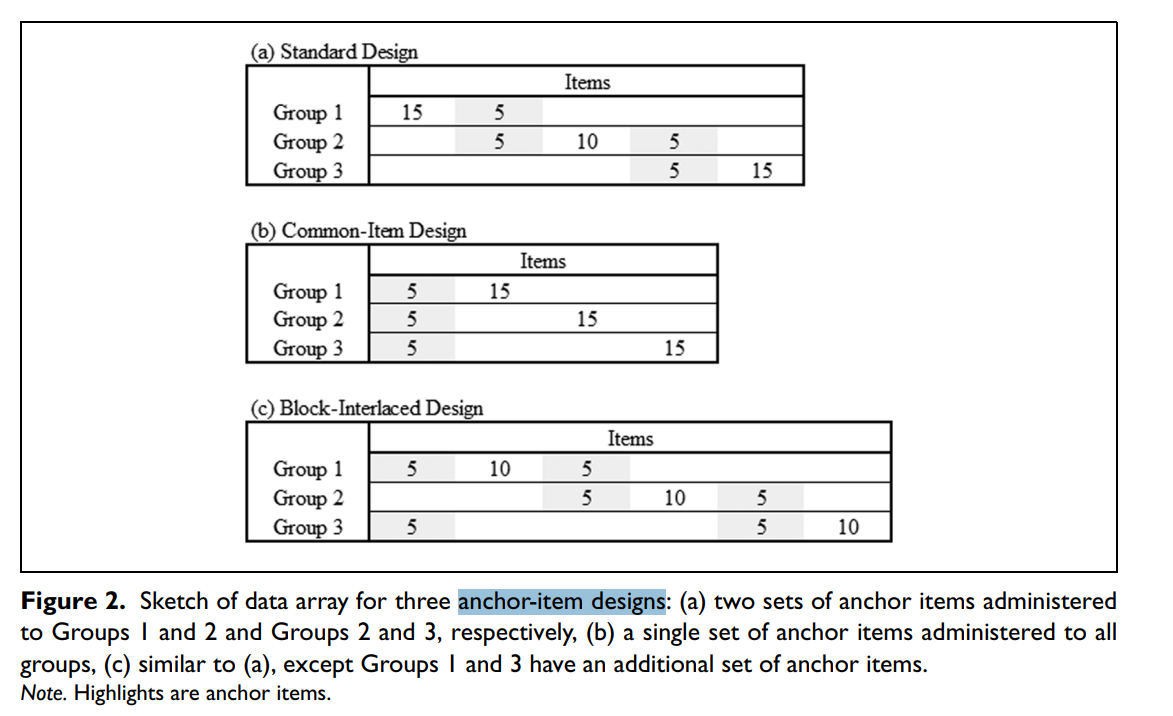

### 有锚题

#### 同一阶段的两两模块之间不可以完全重复 
- Maximum 1 testlets in common between test forms
- $$\sum_{i=1,...,I}x_{it}x_{it^{\prime}}\leq\text{overlapMAХ}_{tt^{\prime}}\quad\forall t\neq t^{\prime}$$
$$
\begin{aligned}
\begin{aligned}\sum_{i=1}^{I}z_{itt'}\le n_{tt'}^{\max},\end{aligned}   \\
\begin{aligned}\sum_{i=1}^Iz_{itt'}&\ge n_{tt'}^{\min},\end{aligned} \\
2z_{itt^{\prime}}\leq x_{it}+x_{it^{\prime}},\quad\mathrm{for~all~}i, \\
z_{itt^{\prime}}\geq x_{it}+x_{it^{\prime}}-1,\quad\mathrm{for~all~}i.
\end{aligned}
$$

- 这里采用quadratic的约束

In [15]:
## Core Stage
Cons_Maximun_testlet_common_Core_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Core_Stage'] * xPanal2[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal1_Panal2')
Cons_Maximun_testlet_common_Core_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Core_Stage'] * xPanal3[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal1_Panal3')
Cons_Maximun_testlet_common_Core_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Core_Stage'] * xPanal4[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal1_Panal4')
Cons_Maximun_testlet_common_Core_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Core_Stage'] * xPanal3[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal2_Panal3')
Cons_Maximun_testlet_common_Core_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Core_Stage'] * xPanal4[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal2_Panal4')
Cons_Maximun_testlet_common_Core_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Core_Stage'] * xPanal4[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal3_Panal4')

## Stage 1H
Cons_Maximun_testlet_common_Stage1H_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Stage_1H'] * xPanal2[t,'Stage_1H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1H_Panal1_Panal2')
Cons_Maximun_testlet_common_Stage1H_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Stage_1H'] * xPanal3[t,'Stage_1H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1H_Panal1_Panal3')
Cons_Maximun_testlet_common_Stage1H_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Stage_1H'] * xPanal4[t,'Stage_1H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1H_Panal1_Panal4')
Cons_Maximun_testlet_common_Stage1H_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Stage_1H'] * xPanal3[t,'Stage_1H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1H_Panal2_Panal3')
Cons_Maximun_testlet_common_Stage1H_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Stage_1H'] * xPanal4[t,'Stage_1H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1H_Panal2_Panal4')
Cons_Maximun_testlet_common_Stage1H_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Stage_1H'] * xPanal4[t,'Stage_1H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1H_Panal3_Panal4')

## Stage 1L
Cons_Maximun_testlet_common_Stage1L_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Stage_1L'] * xPanal2[t,'Stage_1L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1L_Panal1_Panal2')
Cons_Maximun_testlet_common_Stage1L_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Stage_1L'] * xPanal3[t,'Stage_1L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1L_Panal1_Panal3')
Cons_Maximun_testlet_common_Stage1L_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Stage_1L'] * xPanal4[t,'Stage_1L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1L_Panal1_Panal4')
Cons_Maximun_testlet_common_Stage1L_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Stage_1L'] * xPanal3[t,'Stage_1L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1L_Panal2_Panal3')
Cons_Maximun_testlet_common_Stage1L_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Stage_1L'] * xPanal4[t,'Stage_1L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1L_Panal2_Panal4')
Cons_Maximun_testlet_common_Stage1L_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Stage_1L'] * xPanal4[t,'Stage_1L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage1L_Panal3_Panal4')

## Stage 2H
Cons_Maximun_testlet_common_Stage2H_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Stage_2H'] * xPanal2[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal1_Panal2')
Cons_Maximun_testlet_common_Stage2H_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Stage_2H'] * xPanal3[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal1_Panal3')
Cons_Maximun_testlet_common_Stage2H_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Stage_2H'] * xPanal4[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal1_Panal4')
Cons_Maximun_testlet_common_Stage2H_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Stage_2H'] * xPanal3[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal2_Panal3')
Cons_Maximun_testlet_common_Stage2H_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Stage_2H'] * xPanal4[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal2_Panal4')
Cons_Maximun_testlet_common_Stage2H_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Stage_2H'] * xPanal4[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal3_Panal4')

## Stage 2L
Cons_Maximun_testlet_common_Stage2L_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Stage_2L'] * xPanal2[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal1_Panal2')
Cons_Maximun_testlet_common_Stage2L_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Stage_2L'] * xPanal3[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal1_Panal3')
Cons_Maximun_testlet_common_Stage2L_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Stage_2L'] * xPanal4[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal1_Panal4')
Cons_Maximun_testlet_common_Stage2L_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Stage_2L'] * xPanal3[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal2_Panal3')
Cons_Maximun_testlet_common_Stage2L_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Stage_2L'] * xPanal4[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal2_Panal4')
Cons_Maximun_testlet_common_Stage2L_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Stage_2L'] * xPanal4[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal3_Panal4')


#### 每个题在一个阶段最多使用两次
-  Maximum testlet use is 2

In [16]:
## Core Stage
Cons_Maximun_testlet_use_Core = model.addConstrs((xPanal1[t,'Core_Stage']+xPanal2[t,'Core_Stage']+xPanal3[t,'Core_Stage']+xPanal4[t,'Core_Stage']<=2 for t in T),name='Cons_Maximun_testlet_use_Core')

## Stage 1H
Cons_Maximun_testlet_use_Stage1H = model.addConstrs((xPanal1[t,'Stage_1H']+xPanal2[t,'Stage_1H']+xPanal3[t,'Stage_1H']+xPanal4[t,'Stage_1H']<=2 for t in T),name='Cons_Maximun_testlet_use_Stage1H')

## Stage 1L
Cons_Maximun_testlet_use_Stage1L = model.addConstrs((xPanal1[t,'Stage_1L']+xPanal2[t,'Stage_1L']+xPanal3[t,'Stage_1L']+xPanal4[t,'Stage_1L']<=2 for t in T),name='Cons_Maximun_testlet_use_Stage1L')

## Stage 2H
Cons_Maximun_testlet_use_Stage2H = model.addConstrs((xPanal1[t,'Stage_2H']+xPanal2[t,'Stage_2H']+xPanal3[t,'Stage_2H']+xPanal4[t,'Stage_2H']<=2 for t in T),name='Cons_Maximun_testlet_use_Stage2H')

## Stage 2L
Cons_Maximun_testlet_use_Stage2L = model.addConstrs((xPanal1[t,'Stage_2L']+xPanal2[t,'Stage_2L']+xPanal3[t,'Stage_2L']+xPanal4[t,'Stage_2L']<=2 for t in T),name='Cons_Maximun_testlet_use_Stage2L')

### 无锚题(这是一个测试看看能不能得到IIS)

In [17]:
# balabala = model.addConstrs((xPanal1.sum(t,'*') + xPanal2.sum(t,'*') + xPanal3.sum(t,'*') + xPanal4.sum(t,'*') <= 1 for t in T),name='a') # 很显然模型无解，即不可行

## 目标函数(多目标)

- Maxmin 目标是相对的
$$
\begin{array}{l}\mathrm{maximize~y,}\\\mathrm{subject~to~y\leq Ax,}\\\mathrm{and~x\in\{0,~1\},~y>0.}\end{array}
$$

- Capped Maxmin 目标是相对的
$$
\begin{array}{l}\mathrm{maximize~y-\delta,}\\\mathrm{subject~to~y\leq Ax\leq y+\delta,}\\\mathrm{and~x\in\{0,~1\},~y>0,~\delta>0.}\end{array}
$$

- Minmax 目标是绝对的
$$
\begin{array}{l}\mathrm{minimize~}y,\\\mathrm{subject~to~}\boldsymbol{t}-y\leq\boldsymbol{Ax}\leq\boldsymbol{t}+y,\\\mathrm{and~}\boldsymbol{x}\in\{0,\quad1\},\quad y>0,\end{array}$$

- Binary Minmax 目标是绝对的
$$
\begin{array}{l}\mathrm{minimize~}y_l+y_u,\\\mathrm{subject~to~}\boldsymbol{t}-y_l\leq\boldsymbol{Ax}\leq\boldsymbol{t}+y_u,\\\mathrm{and~}\boldsymbol{x}\in\{0,\quad1\},\quad y_l>0,\quad y_u>0,\end{array}$$

- PISA本身的设计并没有严格地符合完全的平行，信息量的总量会有一些差距，因此采用**Maxmin类**的方法进行目标函数的建模，并设置下限，同时为了避免需要优化太多的目标函数，采用如下公式：
  \begin{gathered}\text{maximize }y\\\sum_{i=1}^II_i(\theta_k)x_{it}\geq\mathcal{R}_{kt}y,\quad\text{for all }k\quad\text{and }t,\\y\geq0.\end{gathered}

  同时规定y的下限为1

  see more from Linear_Models_for_Optimal_Test_Design p164

In [18]:
## 构建变量y
y = model.addVar(lb=1.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name='y')


## 设置目标函数约束条件
### Panal 1
#### Core Stage
Cons_Panal1_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal1[t,'Core_Stage'] for t in T]) >= InformationPerModule_weight[0]*y,name='Cons_Panal1_LB_Object_Core')
#### Stage 1
Cons_Panal1_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal1[t,'Stage_1H'] for t in T]) >= InformationPerModule_weight[1]*y,name='Cons_Panal1_LB_Object_Stage1H')
Cons_Panal1_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal1[t,'Stage_1L'] for t in T]) >= InformationPerModule_weight[2]*y,name='Cons_Panal1_LB_Object_Stage1L')
#### Stage 2
Cons_Panal1_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal1[t,'Stage_2H'] for t in T]) >= InformationPerModule_weight[3]*y,name='Cons_Panal1_LB_Object_Stage2H')
Cons_Panal1_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal1[t,'Stage_2L'] for t in T]) >= InformationPerModule_weight[4]*y,name='Cons_Panal1_LB_Object_Stage2L')


### Panal 2
#### Core Stage
Cons_Panal2_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal2[t,'Core_Stage'] for t in T]) >= InformationPerModule_weight[0]*y,name='Cons_Panal2_LB_Object_Core')
#### Stage 1
Cons_Panal2_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal2[t,'Stage_1H'] for t in T]) >= InformationPerModule_weight[1]*y,name='Cons_Panal2_LB_Object_Stage1H')
Cons_Panal2_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal2[t,'Stage_1L'] for t in T]) >= InformationPerModule_weight[2]*y,name='Cons_Panal2_LB_Object_Stage1L')
#### Stage 2
Cons_Panal2_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal2[t,'Stage_2H'] for t in T]) >= InformationPerModule_weight[3]*y,name='Cons_Panal2_LB_Object_Stage2H')
Cons_Panal2_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal2[t,'Stage_2L'] for t in T]) >= InformationPerModule_weight[4]*y,name='Cons_Panal2_LB_Object_Stage2L')


### Panal 3
#### Core Stage
Cons_Panal3_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal3[t,'Core_Stage'] for t in T]) >= InformationPerModule_weight[0]*y,name='Cons_Panal3_LB_Object_Core')
#### Stage 1
Cons_Panal3_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal3[t,'Stage_1H'] for t in T]) >= InformationPerModule_weight[1]*y,name='Cons_Panal3_LB_Object_Stage1H')
Cons_Panal3_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal3[t,'Stage_1L'] for t in T]) >= InformationPerModule_weight[2]*y,name='Cons_Panal3_LB_Object_Stage1L')
#### Stage 2
Cons_Panal3_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal3[t,'Stage_2H'] for t in T]) >= InformationPerModule_weight[3]*y,name='Cons_Panal3_LB_Object_Stage2H')
Cons_Panal3_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal3[t,'Stage_2L'] for t in T]) >= InformationPerModule_weight[4]*y,name='Cons_Panal3_LB_Object_Stage2L')

### Panal 4
#### Core Stage
Cons_Panal4_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal4[t,'Core_Stage'] for t in T]) >= InformationPerModule_weight[0]*y,name='Cons_Panal4_LB_Object_Core')
#### Stage 1
Cons_Panal4_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal4[t,'Stage_1H'] for t in T]) >= InformationPerModule_weight[1]*y,name='Cons_Panal4_LB_Object_Stage1H')
Cons_Panal4_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal4[t,'Stage_1L'] for t in T]) >= InformationPerModule_weight[2]*y,name='Cons_Panal4_LB_Object_Stage1L')
#### Stage 2
Cons_Panal4_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal4[t,'Stage_2H'] for t in T]) >= InformationPerModule_weight[3]*y,name='Cons_Panal4_LB_Object_Stage2H')
Cons_Panal4_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal4[t,'Stage_2L'] for t in T]) >= InformationPerModule_weight[4]*y,name='Cons_Panal4_LB_Object_Stage2L')


## 设置目标函数
model.setObjective(y, GRB.MAXIMIZE)

## 模型求解

In [19]:
# deepcopy一个model实例
model.update()
model_copy = model.copy()

In [20]:
# 保存模型
model_copy.write('MP_ATA.lp')


- <font color="red">由于模型中所有的变量都是binary的0，1变量，因此当模型不可行时只能够改变约束条件而不可以改变变量的界限</font>
  - `vars = None`
  - `vrelax = False`
- IIS results are returned in a number of attributes: IISConstr, IISLB, IISUB, IISSOS, IISQConstr, and IISGenConstr. Each indicates whether the corresponding model element is a member of the computed IIS.
  - `model.IISConstr()` returns a list 可以在对应位置设置其为0或1


In [21]:
model_copy.setParam('DualReductions', 0)

# 求解模型
model_copy.optimize()

# Status checking
status = model_copy.Status
if status is GRB.INFEASIBLE:
    
    print('The model cannot be solved because it is infeasible.')
    
    # https://support.gurobi.com/hc/en-us/articles/360041448572-How-does-Gurobi-compute-the-IIS-for-infeasible-models
    # https://pubsonline.informs.org/doi/10.1287/ijoc.2.1.61
    
    """
    The IISConstrForce, IISLBForce, IISUBForce, IISSOSForce, IISQConstrForce, and IISGenConstrForce attributes allow you mark model elements to either include or exclude from the computed IIS. 
    Setting the attribute to 1 forces the corresponding element into the IIS, setting it to 0 forces it out of the IIS, and setting it to -1 allows the algorithm to decide.

    To give an example of when these attributes might be useful, consider the case where an initial model is known to be feasible, but it becomes infeasible after adding constraints or tightening bounds. 
    If you are only interested in knowing which of the changes caused the infeasibility, you can force the unmodified bounds and constraints into the IIS. That allows the IIS algorithm to focus exclusively
    on the new constraints, which will often be substantially faster.
    
    IISConstrForce、IISLBForce、IISUBForce、IISSOSForce、IISQConstrForce 和 IISGenConstrForce 这些属性能够标记模型元素，使其被包括或排除在计算的 IIS 中。
    将属性设为 1 将会强制将对应元素纳入 IIS，设为 0 则将其排除在外，设为 -1 则让算法自行决定。

    举个例子来说明这些属性何时有用：假设一个初始模型是可行的，但在添加约束或收紧边界后变得不可行。如果你只想知道哪些变动导致了不可行性，你可以强制将未改动的边界和约束纳入 IIS。
    这样一来，IIS 算法就可以专注于新约束，通常能更快地找到答案。
    """
    
    
    
    # model_copy.setParam('IISGenConstrForce', 0) # 不考虑indicator约束
    model_copy.computeIIS()
    model_copy.write("MP_ATA.ilp")
    
    # Print out the IIS constraints and variables
    print('\nThe following linear constraints and variables are in the IIS:')
    print('\n----Linear Constraints----')
    for c in model_copy.getConstrs():
        if c.IISConstr: print(f'\t{c.constrname}: {model_copy.getRow(c)} {c.Sense} {c.RHS}')

    print('\n----Variables----')
    for v in model_copy.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
        
    if relaxed:
        print('The model is infeasible; relaxing the bounds')
        orignumvars = model_copy.NumVars
        """
        https://www.gurobi.com/documentation/current/refman/py_model_feasrelaxs.html
        model.feasRelaxS()
            Arguments:

                - relaxobjtype: The cost function used when finding the minimum cost relaxation.

                - minrelax: The type of feasibility relaxation to perform.

                - vrelax: Indicates whether variable bounds can be relaxed.

                - crelax: Indicates whether constraints can be relaxed.

            Return value:

                Zero if minrelax is False. If minrelax is True, the return value is the objective value for the relaxation performed. 
                If the value is less than 0, it indicates that the method failed to create the feasibility relaxation.
        """
        
        # relaxing only variable bounds
        # model_copy.feasRelaxS(0, False, True, False)
        # for relaxing only constraint bounds use 
        model_copy.feasRelaxS(0, False, False, True) 
        # for relaxing variable bounds and constraint bounds use 
        # m.feasRelaxS(0, False, True, True)
        
        """
        https://www.gurobi.com/documentation/current/refman/py_model_feasrelax.html
        model.feasRelax()
            Arguments:

                - relaxobjtype: The cost function used when finding the minimum cost relaxation.

                - minrelax: The type of feasibility relaxation to perform.

                - vars: Variables whose bounds are allowed to be violated.

                - lbpen: Penalty for violating a variable lower bound. One entry for each variable in argument vars.

                - ubpen: Penalty for violating a variable upper bound. One entry for each variable in argument vars.

                - constrs: Linear constraints that are allowed to be violated.

                - rhspen: Penalty for violating a linear constraint. One entry for each constraint in argument constrs.

            Return value:

                Zero if minrelax is False. If minrelax is True, the return value is the objective value for the relaxation performed. 
                If the value is less than 0, it indicates that the method failed to create the feasibility relaxation.
        """
        # 我要控制我想放松的那些变量上面
        # vars = model.getVars()
        # ubpen = [1.0]*model.numVars
        # model.feasRelax(1, False, vars, None, ubpen, None, None)
        # model.optimize()
        
        
        model_copy.optimize()

        status = model_copy.Status
        if status is GRB.INFEASIBLE:
            print('The relaxed model cannot be solved \
                because it is infeasible.')
            # sys.exit(1)
        if status != GRB.OPTIMAL:
            print('Optimization was stopped with status %d' % status)
            # sys.exit(1)
        
        # print the values of the artificial variables of the relaxation
        print('\nSlack values:')
        slacks = model_copy.getVars()[orignumvars:]
        for sv in slacks:
            if sv.X > 1e-9:
                print('%s = %g' % (sv.VarName, sv.X))
    
    # sys.exit(0)
    
    
if status is GRB.OPTIMAL:
    print('Optimization was stopped with status ' + str(status))
    
    # 展示决策变量求解结果
    for v in model_copy.getVars():
        if v.x > 1e-6:
            print(v.varName, v.x)
    # 展示目标函数数值
    print('Total matching score: ', model_copy.objVal)
    
    # sys.exit(0)

Set parameter DualReductions to value 0
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 510 rows, 905 columns and 9540 nonzeros
Model fingerprint: 0xee6ed278
Model has 30 quadratic constraints
Model has 304 general constraints
Variable types: 1 continuous, 904 integer (904 binary)
Coefficient statistics:
  Matrix range     [1e-01, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
  QRHS range       [1e+00, 1e+00]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 170 rows and 0 columns
Presolve removed 0 rows and 216 columns
Presolve time: 0.03s

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 1 (of 8 avai